### <b> PySpark vs GCP </b>

#### <b> PySpark </b>

In [77]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, when, datediff, hour, minute, count, avg, stddev, min, max, desc, countDistinct, sum as spark_sum, max as spark_max
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import xgboost as xgb

In [4]:
time_markings_spark = {
    "load": [],
    "query": [],
}

In [5]:
import psutil

# Print your system's available memory
mem_info = psutil.virtual_memory()
print(f"Total memory: {mem_info.total / (1024**3):.2f} GB")
print(f"Available memory: {mem_info.available / (1024**3):.2f} GB")

Total memory: 18.00 GB
Available memory: 9.51 GB


* <b> Java is required: </b> brew install openjdk@11 (MacOs) OR sudo apt install openjdk-11-jdk (Ubuntu)


#### <b> Spark and CSV data loading functions </b>

In [6]:
# spark.driver.memory: Used by the main program that orchestrates tasks (Stores task results, coordinates actions, loads final DataFrames)
# spark.executor.memory: Used by worker processes that execute individual tasks (Data processing, transformations, aggregations, shuffling)
# spark.driver.maxResultSize: limits the total size of serialized results that can be returned to the driver from all partitions in a single Spark operation
def initialize_spark():
    '''
    Description: Initialize Spark Session

    Arguments: 
        -None
    Output: 
        -Spark session
    '''
    spark = SparkSession.builder \
                        .appName("MIMIC-III LOS Prediction") \
                        .config("spark.driver.memory", "12g") \
                        .config("spark.executor.memory", "12g") \
                        .config("spark.driver.maxResultSize", "6g") \
                        .getOrCreate()

    # Check initialization
    print("Success! Spark is working.")
    print(f"Spark version: {spark.version}\n")

    return spark

def load_csv_table(spark, csv_dir, table_name):
    """Load a CSV table with performance timing."""
    csv_path = os.path.join(csv_dir, f"{table_name.upper()}.csv")
    
    print(f"Loading {table_name} from CSV...")
    start_time = time.time()
    
    
    df = spark.read.csv(csv_path, header=True, inferSchema=True)
    df = df.drop("ROW_ID")
    
    # Force action to measure full load time
    count = df.count()
    end_time = time.time()
    
    print(f"Loaded {table_name}: {count} rows in {end_time - start_time:.2f} seconds")
    return df

In [7]:
def load_csv_table(spark, csv_dir, table_name):
    """Load a CSV table with performance timing."""
    csv_path = os.path.join(csv_dir, f"{table_name.upper()}.csv")

    print(f"Loading {table_name} from CSV...")
    start_time = time.time()


    df = spark.read.csv(csv_path, header=True, inferSchema=True)
    df = df.drop("ROW_ID")
    count = df.count()
    end_time = time.time()
    totalTime = end_time - start_time
    time_markings_spark["load"].append(totalTime)

    print(f"Loaded {table_name}: {count} rows in {end_time - start_time:.2f} seconds")
    return df

In [8]:
spark = initialize_spark()

init_time = time.time()

# Load tables
admissions_df = load_csv_table(spark, "../data/raw", "admissions")
print("\n")
callout_df = load_csv_table(spark, "../data/raw", "callout")
print("\n")
chart_events_df = load_csv_table(spark, "../data/raw", "chartevents")
print("\n")
d_icd_diagnoses = load_csv_table(spark, "../data/raw", "d_icd_diagnoses")
print("\n")
d_items_df = load_csv_table(spark, "../data/raw", "d_items")
print("\n")
diagnoses_icd_df = load_csv_table(spark, "../data/raw", "diagnoses_icd")
print("\n")
icustays_df = load_csv_table(spark, "../data/raw", "icustays")
print("\n")
patients_df = load_csv_table(spark, "../data/raw", "patients")
print("\n")
services_df = load_csv_table(spark, "../data/raw", "services")
print("\n")

final_time = time.time() - init_time

print(f"Total loading time: {final_time}")

25/06/04 16:48:53 WARN Utils: Your hostname, MacBook-Pro-de-Rodrigo.local resolves to a loopback address: 127.0.0.1; using 172.17.18.15 instead (on interface en0)
25/06/04 16:48:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/06/04 16:48:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Success! Spark is working.
Spark version: 3.1.2

Loading admissions from CSV...
Loaded admissions: 58976 rows in 1.83 seconds


Loading callout from CSV...
Loaded callout: 34499 rows in 0.25 seconds


Loading chartevents from CSV...


Loaded chartevents: 330712483 rows in 71.82 seconds


Loading d_icd_diagnoses from CSV...
Loaded d_icd_diagnoses: 14567 rows in 0.28 seconds


Loading d_items from CSV...
Loaded d_items: 12487 rows in 0.14 seconds


Loading diagnoses_icd from CSV...
Loaded diagnoses_icd: 651047 rows in 0.27 seconds


Loading icustays from CSV...
Loaded icustays: 61532 rows in 0.15 seconds


Loading patients from CSV...
Loaded patients: 46520 rows in 0.11 seconds


Loading services from CSV...
Loaded services: 73343 rows in 0.13 seconds


Total loading time: 75.0107798576355


In [9]:
#chart_events_df.show(5)

#### <b> Join tables based on the MIMIC-III dataset structure</b>

* 1 patient can have multiple ICU stays and Admissions
* We can extract total Hospital LOS by subtracting DISCHTIME to ADMITTIME
* We also can extract total ICU LOS

In [10]:
# Let's examine the multiple ICU stays situation
def analyze_multiple_icu_stays(icustays_df):
    """
    Analyze patterns of multiple ICU stays in the dataset.
    """
    print("=== Analysis of Multiple ICU Stays ===")
    
    # Total ICU stays
    total_stays = icustays_df.count()
    print(f"Total ICU stays: {total_stays}")
    
    # Unique patients
    unique_patients = icustays_df.select("SUBJECT_ID").distinct().count()
    print(f"Unique patients: {unique_patients}")
    
    # Unique hospital admissions
    unique_admissions = icustays_df.select("HADM_ID").distinct().count()
    print(f"Unique hospital admissions: {unique_admissions}")
    
    # Patients with multiple ICU stays (any combination)
    patients_multiple_stays = icustays_df.groupBy("SUBJECT_ID") \
        .agg(count("ICUSTAY_ID").alias("icu_stays_count")) \
        .filter("icu_stays_count > 1")
    
    multiple_stays_count = patients_multiple_stays.count()
    print(f"Patients with multiple ICU stays: {multiple_stays_count}")
    
    # Distribution of ICU stays per patient
    print("\nDistribution of ICU stays per patient:")
    icustays_df.groupBy("SUBJECT_ID") \
        .agg(count("ICUSTAY_ID").alias("stays_count")) \
        .groupBy("stays_count") \
        .agg(count("SUBJECT_ID").alias("patient_count")) \
        .orderBy("stays_count") \
        .show()
    
    
    # Multiple ICU stays within same hospital admission
    same_admission_multiple = icustays_df.groupBy("HADM_ID") \
        .agg(count("ICUSTAY_ID").alias("icu_stays_in_admission")) \
        .filter("icu_stays_in_admission > 1")
    
    same_admission_count = same_admission_multiple.count()
    print(f"Hospital admissions with multiple ICU stays: {same_admission_count}")
    
    # Show examples
    print("\nExamples of patients with multiple ICU stays:")
    icustays_df.join(patients_multiple_stays.limit(3), "SUBJECT_ID") \
        .select("SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "INTIME", "OUTTIME", "LOS") \
        .orderBy("SUBJECT_ID", "INTIME") \
        .show(truncate=False)
    
    return {
        "total_stays": total_stays,
        "unique_patients": unique_patients,
        "patients_with_multiple_stays": multiple_stays_count,
        "admissions_with_multiple_icu_stays": same_admission_count
    }



# Run the analysis
stats = analyze_multiple_icu_stays(icustays_df)

=== Analysis of Multiple ICU Stays ===
Total ICU stays: 61532
Unique patients: 46476
Unique hospital admissions: 57786
Patients with multiple ICU stays: 8755

Distribution of ICU stays per patient:
+-----------+-------------+
|stays_count|patient_count|
+-----------+-------------+
|          1|        37721|
|          2|         5796|
|          3|         1619|
|          4|          650|
|          5|          300|
|          6|          151|
|          7|           86|
|          8|           44|
|          9|           29|
|         10|           19|
|         11|           15|
|         12|           11|
|         13|            8|
|         14|            4|
|         15|            6|
|         16|            2|
|         17|            2|
|         18|            2|
|         20|            1|
|         21|            2|
+-----------+-------------+
only showing top 20 rows

Hospital admissions with multiple ICU stays: 3260

Examples of patients with multiple ICU stays:
+------

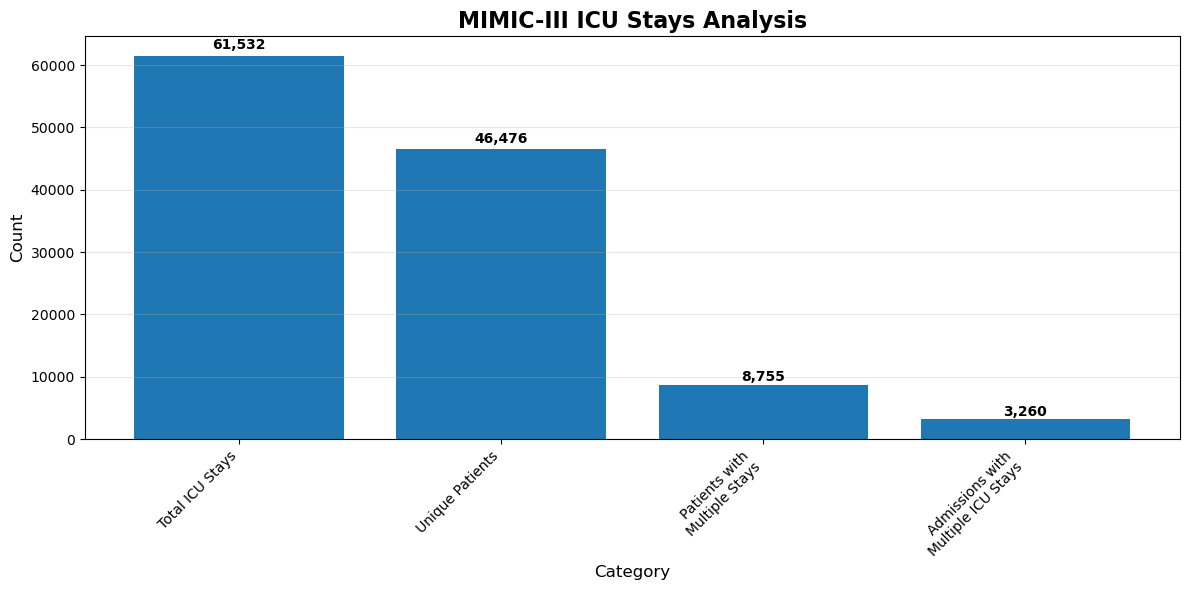

In [11]:
import matplotlib.pyplot as plt

xx = []
total_stays = stats["total_stays"]
xx.append(total_stays)
unique_patients = stats["unique_patients"]
xx.append(unique_patients)
patients_with_multiple_stays = stats["patients_with_multiple_stays"]
xx.append(patients_with_multiple_stays)
admissions_with_multiple_icu_stays = stats["admissions_with_multiple_icu_stays"]
xx.append(admissions_with_multiple_icu_stays)

# Create labels for the x-axis
labels = ['Total ICU Stays', 'Unique Patients', 'Patients with\nMultiple Stays', 'Admissions with\nMultiple ICU Stays']
# Create values for the y-axis (your actual data)
values = xx

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values)

# Add value labels on top of each bar - using a fixed offset instead of percentage
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01, 
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

# Customize the plot
plt.title('MIMIC-III ICU Stays Analysis', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)

# Rotate x-axis labels if needed for better readability
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
plt.grid(axis='y', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
stats

{'total_stays': 61532,
 'unique_patients': 46476,
 'patients_with_multiple_stays': 8755,
 'admissions_with_multiple_icu_stays': 3260}

Let's join <b> ICUSTAYS and ADMISSIONS </b> table to get relevant information from patients that were admitted to the ICU when they went to the hospital, and exclude those that didn't

In [13]:
new_icustays_df = icustays_df.join(admissions_df, on=["SUBJECT_ID", "HADM_ID"], how="left")

In [14]:
#new_icustays_df.show(5)

ICU STAYS + ADMISSIONS DATA ANALYSIS
Total records after join: 61,532
Null values in SUBJECT_ID: 0
Null values in HADM_ID: 0
Null values in ICUSTAY_ID: 0
Null values in INTIME: 0
Null values in OUTTIME: 10
Null values in ADMITTIME: 0
Null values in DISCHTIME: 0

Converting sample to Pandas for analysis...


25/06/04 16:50:13 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


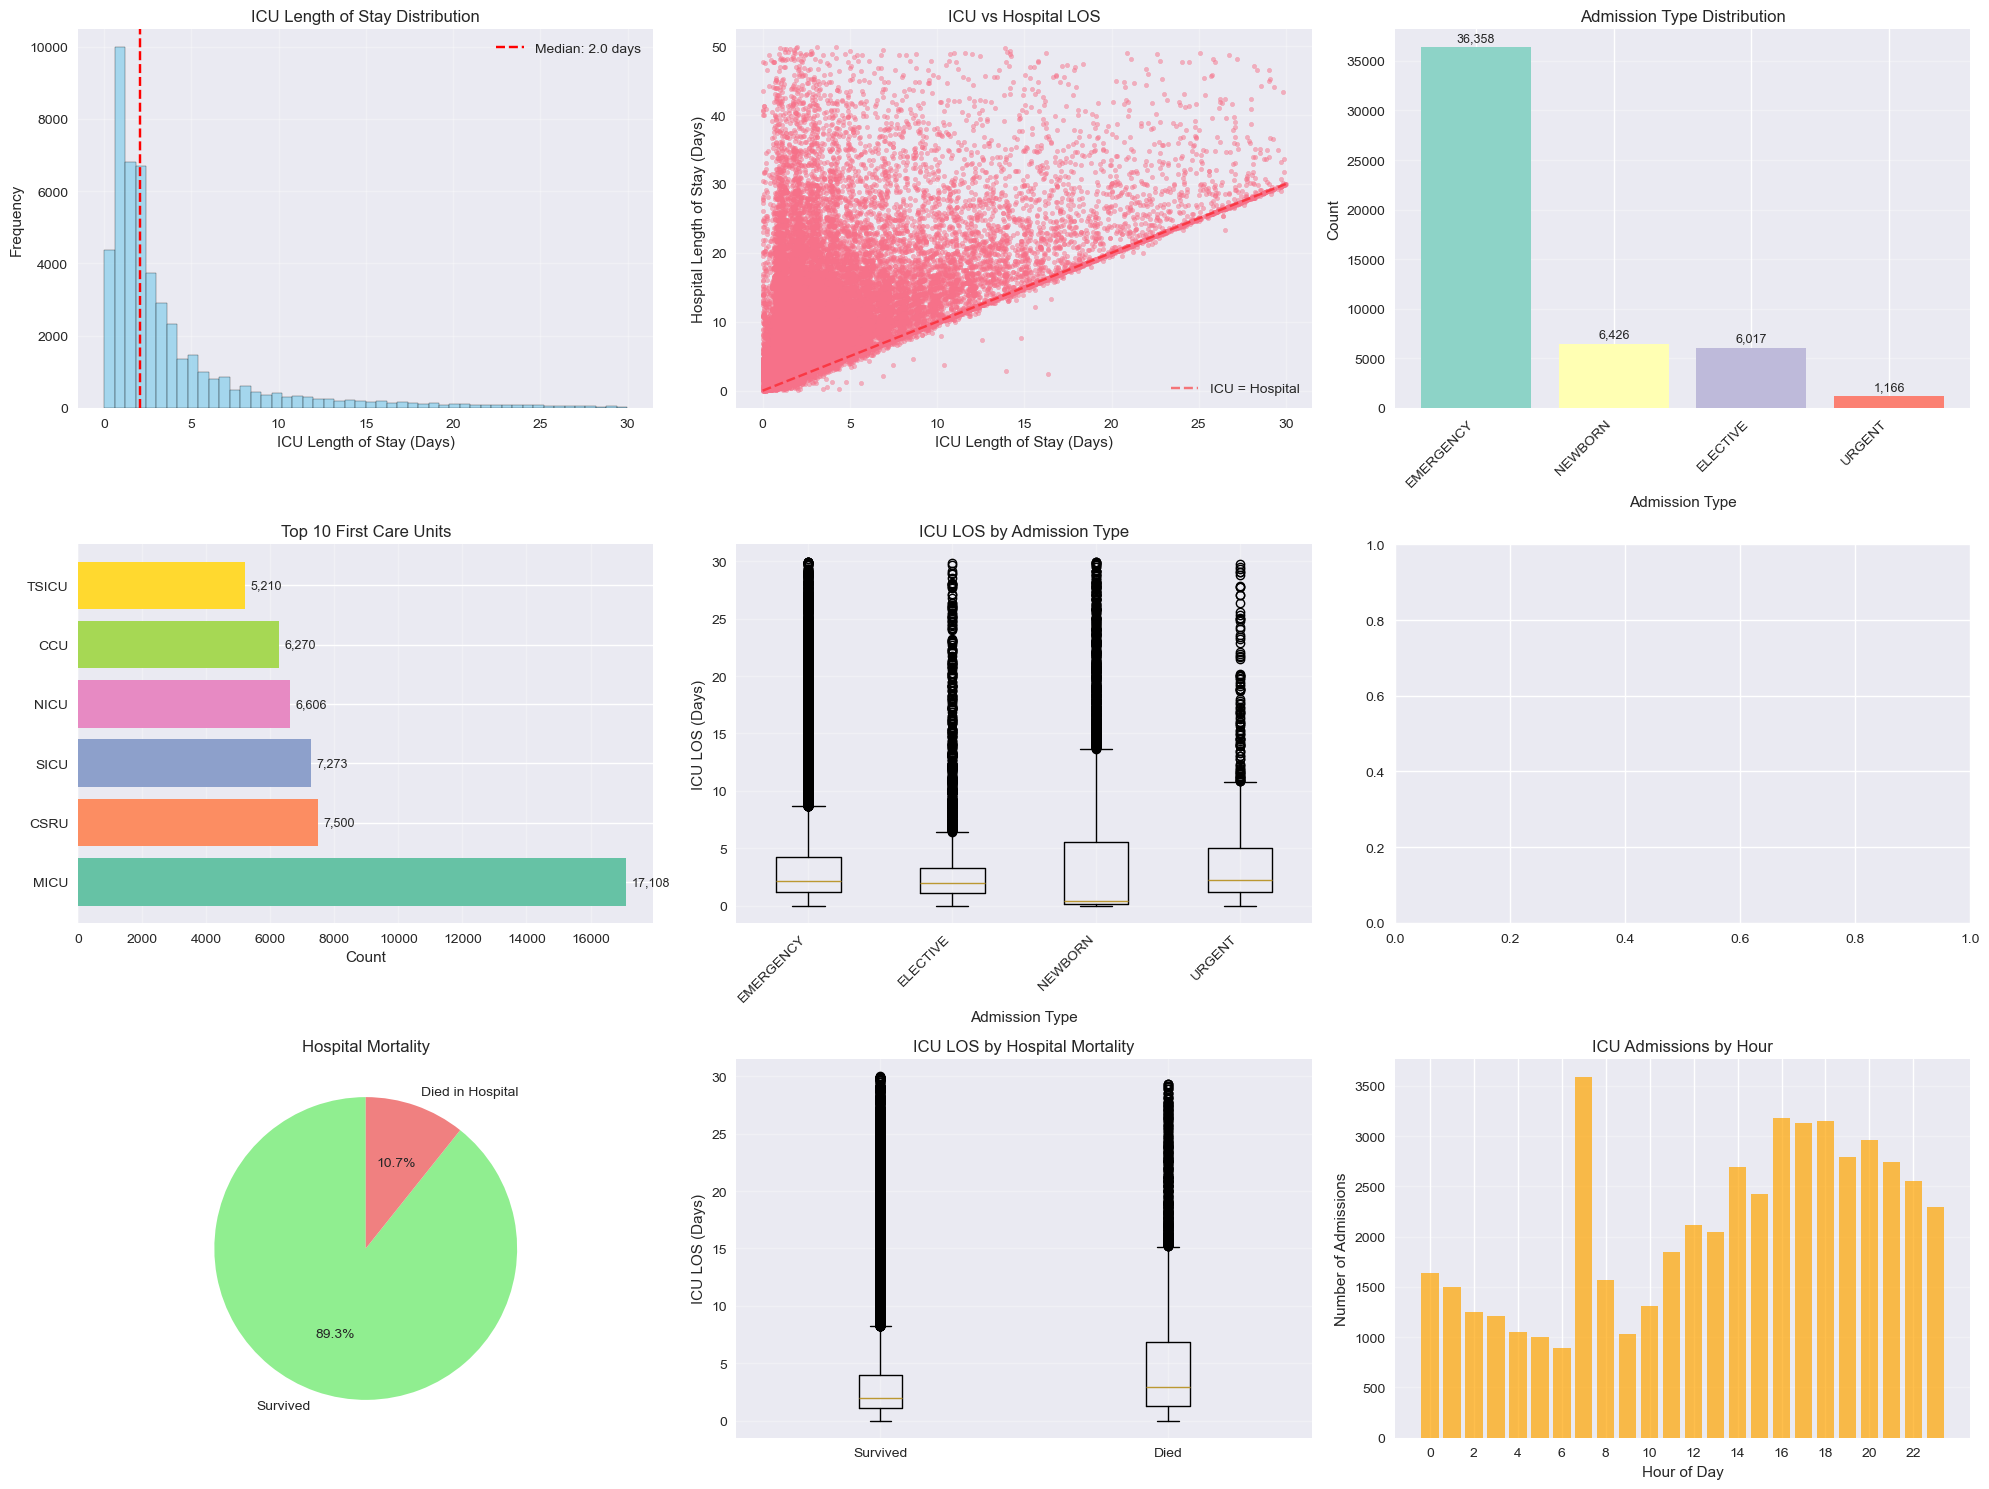


SUMMARY STATISTICS

ICU Length of Stay (Days):
  Mean: 4.90
  Median: 2.09
  Std: 9.57
  Min: 0.00
  Max: 173.07

Hospital Mortality Rate: 10.7%

Most common admission types:
  1. EMERGENCY: 36,358 (72.8%)
  2. NEWBORN: 6,426 (12.9%)
  3. ELECTIVE: 6,017 (12.0%)


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pyspark.sql.functions import col, count, avg, min as spark_min, max as spark_max, stddev, when, isnan, isnull
from datetime import datetime

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def analyze_icustay_admission_join(new_icustays_df):
    """
    Comprehensive analysis of the ICU stays + admissions joined data
    """
    print("="*60)
    print("ICU STAYS + ADMISSIONS DATA ANALYSIS")
    print("="*60)
    
    # 1. Basic join statistics
    total_records = new_icustays_df.count()
    print(f"Total records after join: {total_records:,}")
    
    # Check for null values in key columns
    key_columns = ["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "INTIME", "OUTTIME", "ADMITTIME", "DISCHTIME"]
    null_counts = {}
    for col_name in key_columns:
        if col_name in new_icustays_df.columns:
            null_count = new_icustays_df.filter(col(col_name).isNull()).count()
            null_counts[col_name] = null_count
            print(f"Null values in {col_name}: {null_count:,}")
    
    # Convert to Pandas for detailed analysis and visualization
    print("\nConverting sample to Pandas for analysis...")
    
    # Sample for analysis (adjust size based on your memory)
    sample_size = 50000 if total_records > 50000 else total_records  # Adjust as needed
    sample_df = new_icustays_df.sample(fraction=sample_size/total_records, seed=42).toPandas()
    
    # Convert datetime columns
    datetime_cols = ['INTIME', 'OUTTIME', 'ADMITTIME', 'DISCHTIME', 'DOB', 'DOD']
    for col_name in datetime_cols:
        if col_name in sample_df.columns:
            sample_df[col_name] = pd.to_datetime(sample_df[col_name], errors='coerce')
    
    # Calculate lengths of stay
    if 'INTIME' in sample_df.columns and 'OUTTIME' in sample_df.columns:
        sample_df['ICU_LOS_HOURS'] = (sample_df['OUTTIME'] - sample_df['INTIME']).dt.total_seconds() / 3600
        sample_df['ICU_LOS_DAYS'] = sample_df['ICU_LOS_HOURS'] / 24
    
    if 'ADMITTIME' in sample_df.columns and 'DISCHTIME' in sample_df.columns:
        sample_df['HOSPITAL_LOS_HOURS'] = (sample_df['DISCHTIME'] - sample_df['ADMITTIME']).dt.total_seconds() / 3600
        sample_df['HOSPITAL_LOS_DAYS'] = sample_df['HOSPITAL_LOS_HOURS'] / 24
    
    # Create visualizations
    fig = plt.figure(figsize=(20, 15))
    
    # 1. ICU Length of Stay Distribution
    plt.subplot(3, 3, 1)
    if 'ICU_LOS_DAYS' in sample_df.columns:
        # Remove outliers for better visualization
        los_clean = sample_df['ICU_LOS_DAYS'].dropna()
        los_clean = los_clean[(los_clean > 0) & (los_clean < 30)]  # Focus on reasonable range
        
        plt.hist(los_clean, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        plt.xlabel('ICU Length of Stay (Days)')
        plt.ylabel('Frequency')
        plt.title('ICU Length of Stay Distribution')
        plt.axvline(los_clean.median(), color='red', linestyle='--', label=f'Median: {los_clean.median():.1f} days')
        plt.legend()
        plt.grid(alpha=0.3)
    
    # 2. Hospital vs ICU Length of Stay
    plt.subplot(3, 3, 2)
    if 'ICU_LOS_DAYS' in sample_df.columns and 'HOSPITAL_LOS_DAYS' in sample_df.columns:
        # Clean data for scatter plot
        plot_data = sample_df[['ICU_LOS_DAYS', 'HOSPITAL_LOS_DAYS']].dropna()
        plot_data = plot_data[(plot_data['ICU_LOS_DAYS'] > 0) & (plot_data['ICU_LOS_DAYS'] < 30) & 
                             (plot_data['HOSPITAL_LOS_DAYS'] > 0) & (plot_data['HOSPITAL_LOS_DAYS'] < 50)]
        
        plt.scatter(plot_data['ICU_LOS_DAYS'], plot_data['HOSPITAL_LOS_DAYS'], 
                   alpha=0.5, s=10)
        plt.xlabel('ICU Length of Stay (Days)')
        plt.ylabel('Hospital Length of Stay (Days)')
        plt.title('ICU vs Hospital LOS')
        
        # Add diagonal line (ICU = Hospital would be impossible, but shows relationship)
        max_icu = plot_data['ICU_LOS_DAYS'].max()
        max_hosp = plot_data['HOSPITAL_LOS_DAYS'].max()
        max_val = max_icu if max_icu < max_hosp else max_hosp
        plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='ICU = Hospital')
        plt.legend()
        plt.grid(alpha=0.3)
    
    # 3. Admission Type Distribution
    plt.subplot(3, 3, 3)
    if 'ADMISSION_TYPE' in sample_df.columns:
        admission_counts = sample_df['ADMISSION_TYPE'].value_counts()
        colors = plt.cm.Set3(range(len(admission_counts)))
        bars = plt.bar(range(len(admission_counts)), admission_counts.values, color=colors)
        plt.xlabel('Admission Type')
        plt.ylabel('Count')
        plt.title('Admission Type Distribution')
        plt.xticks(range(len(admission_counts)), admission_counts.index, rotation=45, ha='right')
        
        # Add value labels
        max_count = admission_counts.max()
        for bar, value in zip(bars, admission_counts.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max_count*0.01,
                    f'{value:,}', ha='center', va='bottom', fontsize=9)
        plt.grid(axis='y', alpha=0.3)
    
    # 4. First Care Unit Distribution
    plt.subplot(3, 3, 4)
    if 'FIRST_CAREUNIT' in sample_df.columns:
        careunit_counts = sample_df['FIRST_CAREUNIT'].value_counts().head(10)  # Top 10
        colors = plt.cm.Set2(range(len(careunit_counts)))
        bars = plt.barh(range(len(careunit_counts)), careunit_counts.values, color=colors)
        plt.yticks(range(len(careunit_counts)), careunit_counts.index)
        plt.xlabel('Count')
        plt.title('Top 10 First Care Units')
        
        # Add value labels
        max_careunit = careunit_counts.max()
        for bar, value in zip(bars, careunit_counts.values):
            plt.text(bar.get_width() + max_careunit*0.01, bar.get_y() + bar.get_height()/2,
                    f'{value:,}', ha='left', va='center', fontsize=9)
        plt.grid(axis='x', alpha=0.3)
    
    # 5. LOS by Admission Type
    plt.subplot(3, 3, 5)
    if 'ADMISSION_TYPE' in sample_df.columns and 'ICU_LOS_DAYS' in sample_df.columns:
        los_by_admission = []
        admission_types = []
        
        for admission_type in sample_df['ADMISSION_TYPE'].dropna().unique():
            los_subset = sample_df[sample_df['ADMISSION_TYPE'] == admission_type]['ICU_LOS_DAYS'].dropna()
            los_subset = los_subset[(los_subset > 0) & (los_subset < 30)]
            if len(los_subset) > 10:  # Only include types with sufficient data
                los_by_admission.append(los_subset)
                admission_types.append(admission_type)
        
        if los_by_admission:
            plt.boxplot(los_by_admission, labels=admission_types)
            plt.xlabel('Admission Type')
            plt.ylabel('ICU LOS (Days)')
            plt.title('ICU LOS by Admission Type')
            plt.xticks(rotation=45, ha='right')
            plt.grid(alpha=0.3)
    
    # 6. Age Distribution
    plt.subplot(3, 3, 6)
    if 'DOB' in sample_df.columns and 'ADMITTIME' in sample_df.columns:
        # Calculate age at admission
        sample_df['AGE_AT_ADMISSION'] = (sample_df['ADMITTIME'] - sample_df['DOB']).dt.days / 365.25
        
        # Handle age > 89 (MIMIC-III shifts these to 300+)
        ages = sample_df['AGE_AT_ADMISSION'].dropna()
        ages_clean = ages[ages < 120]  # Remove shifted ages
        
        plt.hist(ages_clean, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
        plt.xlabel('Age at Admission (Years)')
        plt.ylabel('Frequency')
        plt.title('Age Distribution at ICU Admission')
        plt.axvline(ages_clean.median(), color='red', linestyle='--', 
                   label=f'Median: {ages_clean.median():.1f} years')
        plt.legend()
        plt.grid(alpha=0.3)
    
    # 7. Mortality Analysis
    plt.subplot(3, 3, 7)
    if 'HOSPITAL_EXPIRE_FLAG' in sample_df.columns:
        mortality_counts = sample_df['HOSPITAL_EXPIRE_FLAG'].value_counts()
        labels = ['Survived', 'Died in Hospital']
        colors = ['lightgreen', 'lightcoral']
        
        plt.pie(mortality_counts.values, labels=labels, colors=colors, autopct='%1.1f%%',
               startangle=90)
        plt.title('Hospital Mortality')
    
    # 8. LOS vs Mortality
    plt.subplot(3, 3, 8)
    if 'HOSPITAL_EXPIRE_FLAG' in sample_df.columns and 'ICU_LOS_DAYS' in sample_df.columns:
        survived = sample_df[sample_df['HOSPITAL_EXPIRE_FLAG'] == 0]['ICU_LOS_DAYS'].dropna()
        died = sample_df[sample_df['HOSPITAL_EXPIRE_FLAG'] == 1]['ICU_LOS_DAYS'].dropna()
        
        # Clean data
        survived = survived[(survived > 0) & (survived < 30)]
        died = died[(died > 0) & (died < 30)]
        
        plt.boxplot([survived, died], labels=['Survived', 'Died'])
        plt.ylabel('ICU LOS (Days)')
        plt.title('ICU LOS by Hospital Mortality')
        plt.grid(alpha=0.3)
    
    # 9. Admission Pattern by Hour
    plt.subplot(3, 3, 9)
    if 'ADMITTIME' in sample_df.columns:
        admission_hours = sample_df['ADMITTIME'].dt.hour
        hour_counts = admission_hours.value_counts().sort_index()
        
        plt.bar(hour_counts.index, hour_counts.values, color='orange', alpha=0.7)
        plt.xlabel('Hour of Day')
        plt.ylabel('Number of Admissions')
        plt.title('ICU Admissions by Hour')
        plt.xticks(range(0, 24, 2))
        plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    if 'ICU_LOS_DAYS' in sample_df.columns:
        los_stats = sample_df['ICU_LOS_DAYS'].describe()
        print(f"\nICU Length of Stay (Days):")
        print(f"  Mean: {los_stats['mean']:.2f}")
        print(f"  Median: {los_stats['50%']:.2f}")
        print(f"  Std: {los_stats['std']:.2f}")
        print(f"  Min: {los_stats['min']:.2f}")
        print(f"  Max: {los_stats['max']:.2f}")
    
    if 'HOSPITAL_EXPIRE_FLAG' in sample_df.columns:
        mortality_rate = sample_df['HOSPITAL_EXPIRE_FLAG'].mean() * 100
        print(f"\nHospital Mortality Rate: {mortality_rate:.1f}%")
    
    if 'ADMISSION_TYPE' in sample_df.columns:
        print(f"\nMost common admission types:")
        for i, (admission_type, count) in enumerate(sample_df['ADMISSION_TYPE'].value_counts().head(3).items()):
            print(f"  {i+1}. {admission_type}: {count:,} ({count/len(sample_df)*100:.1f}%)")
    
    return sample_df

# Usage:
sample_analysis = analyze_icustay_admission_join(new_icustays_df)

Now we join the <b> complete ICU data with the PATIENTS info </b>

In [16]:
patients_full_info_df = new_icustays_df.join(patients_df, on="SUBJECT_ID", how="left")

In [17]:
columns=["DOD_HOSP", "DOD_SSN"]
patients_full_info_df = patients_full_info_df.drop(*columns) # redundant since DOD column gives us the same info

In [18]:
#patients_full_info_df.show(5)

In [19]:
# Check if row counts are the same
'''
print(f"ICUSTAYS count: {icustays_df.count()}")
print(f"After joining ADMISSIONS: {new_icustays_df.count()}")
print(f"After joining PATIENTS: {patients_full_info_df.count()}")
'''


'\nprint(f"ICUSTAYS count: {icustays_df.count()}")\nprint(f"After joining ADMISSIONS: {new_icustays_df.count()}")\nprint(f"After joining PATIENTS: {patients_full_info_df.count()}")\n'

Join the <b> DIAGNOSES and D_ICD_DIAGNOSES tables </b> to get diagnoses descriptions based on the ICD9 code

In [20]:
full_diagnosis_data = diagnoses_icd_df.join(d_icd_diagnoses, on="ICD9_CODE", how="left")
full_diagnosis_data = full_diagnosis_data.drop("SHORT_TITLE")

In [21]:
#full_diagnosis_data.show(5)

Now join <b> PATIENT and DIAGNOSES </b> data

In [22]:
patients_full_info_df = patients_full_info_df.join(full_diagnosis_data, on=["SUBJECT_ID","HADM_ID"], how="left")

In [23]:
#patients_full_info_df.show(5)

In [24]:
#distinct_diagnosis = patients_full_info_df.select("LONG_TITLE").distinct()

In [25]:
#patients_full_info_df.count()

In [26]:
#patients_full_info_df.show(5)

In [27]:
# Get top N most frequent diagnoses
top_diagnoses = diagnoses_icd_df.groupBy("ICD9_CODE").count() \
    .orderBy(desc("count")).limit(200)  # Top 200 covers ~80% of cases

In [28]:
rare_diagnoses = diagnoses_icd_df.groupBy("ICD9_CODE").count() \
    .filter(col("count") <= 4000) \
    .orderBy(desc("count"))

In [29]:
def create_icd9_code_based_diagnosis_features(patients_full_info_df):
    """
    Create diagnosis features based on actual ICD-9 code ranges.
    """
    print("Creating ICD-9 code-based diagnosis features...")
    
    # Get base data without diagnoses
    base_cols = [col_name for col_name in patients_full_info_df.columns 
                 if col_name not in ["ICD9_CODE", "LONG_TITLE", "SEQ_NUM"]]
    base_data = patients_full_info_df.select(*base_cols).distinct()
    
    # ICD-9 code-based diagnosis categories
    diagnosis_features = patients_full_info_df.filter(col("ICD9_CODE").isNotNull()) \
        .withColumn("has_infectious", 
                   when(col("ICD9_CODE").rlike("^(001|002|003|004|005|006|007|008|009|01[0-9]|02[0-9]|03[0-9]|04[0-9]|05[0-9]|06[0-9]|07[0-9]|08[0-9]|09[0-9]|1[0-3][0-9])"), 1).otherwise(0)) \
        .withColumn("has_malignancy", 
                   when(col("ICD9_CODE").rlike("^(1[4-9][0-9]|2[0-3][0-9])"), 1).otherwise(0)) \
        .withColumn("has_endocrine", 
                   when(col("ICD9_CODE").rlike("^(2[4-7][0-9])"), 1).otherwise(0)) \
        .withColumn("has_hematologic", 
                   when(col("ICD9_CODE").rlike("^(2[8-9][0-9])"), 1).otherwise(0)) \
        .withColumn("has_psychiatric", 
                   when(col("ICD9_CODE").rlike("^(29[0-9]|30[0-9]|31[0-9])"), 1).otherwise(0)) \
        .withColumn("has_neurological", 
                   when(col("ICD9_CODE").rlike("^(32[0-9]|33[0-9]|34[0-9]|35[0-9]|36[0-9]|37[0-9]|38[0-9])"), 1).otherwise(0)) \
        .withColumn("has_cardiovascular", 
                   when(col("ICD9_CODE").rlike("^(39[0-9]|40[0-9]|41[0-9]|42[0-9]|43[0-9]|44[0-9]|45[0-9])"), 1).otherwise(0)) \
        .withColumn("has_respiratory", 
                   when(col("ICD9_CODE").rlike("^(46[0-9]|47[0-9]|48[0-9]|49[0-9]|50[0-9]|51[0-9])"), 1).otherwise(0)) \
        .withColumn("has_gastrointestinal", 
                   when(col("ICD9_CODE").rlike("^(52[0-9]|53[0-9]|54[0-9]|55[0-9]|56[0-9]|57[0-9])"), 1).otherwise(0)) \
        .withColumn("has_genitourinary", 
                   when(col("ICD9_CODE").rlike("^(58[0-9]|59[0-9]|60[0-9]|61[0-9]|62[0-9])"), 1).otherwise(0)) \
        .withColumn("has_obstetric", 
                   when(col("ICD9_CODE").rlike("^(63[0-9]|64[0-9]|65[0-9]|66[0-9]|67[0-9])"), 1).otherwise(0)) \
        .withColumn("has_skin", 
                   when(col("ICD9_CODE").rlike("^(68[0-9]|69[0-9]|70[0-9])"), 1).otherwise(0)) \
        .withColumn("has_musculoskeletal", 
                   when(col("ICD9_CODE").rlike("^(71[0-9]|72[0-9]|73[0-9])"), 1).otherwise(0)) \
        .withColumn("has_congenital", 
                   when(col("ICD9_CODE").rlike("^(74[0-9]|75[0-9])"), 1).otherwise(0)) \
        .withColumn("has_perinatal", 
                   when(col("ICD9_CODE").rlike("^(76[0-9]|77[0-9])"), 1).otherwise(0)) \
        .withColumn("has_symptoms_signs", 
                   when(col("ICD9_CODE").rlike("^(78[0-9]|79[0-9])"), 1).otherwise(0)) \
        .withColumn("has_trauma", 
                   when(col("ICD9_CODE").rlike("^(8[0-9][0-9]|9[0-9][0-9])"), 1).otherwise(0)) \
        .withColumn("has_external_causes", 
                   when(col("ICD9_CODE").rlike("^(E[0-9])"), 1).otherwise(0)) \
        .withColumn("has_supplemental", 
                   when(col("ICD9_CODE").rlike("^(V[0-9])"), 1).otherwise(0)) \
        .groupBy("ICUSTAY_ID") \
        .agg(
            spark_max("has_infectious").alias("has_infectious"),
            spark_max("has_malignancy").alias("has_malignancy"),
            spark_max("has_endocrine").alias("has_endocrine"),
            spark_max("has_hematologic").alias("has_hematologic"),
            spark_max("has_psychiatric").alias("has_psychiatric"),
            spark_max("has_neurological").alias("has_neurological"),
            spark_max("has_cardiovascular").alias("has_cardiovascular"),
            spark_max("has_respiratory").alias("has_respiratory"),
            spark_max("has_gastrointestinal").alias("has_gastrointestinal"),
            spark_max("has_genitourinary").alias("has_genitourinary"),
            spark_max("has_obstetric").alias("has_obstetric"),
            spark_max("has_skin").alias("has_skin"),
            spark_max("has_musculoskeletal").alias("has_musculoskeletal"),
            spark_max("has_congenital").alias("has_congenital"),
            spark_max("has_perinatal").alias("has_perinatal"),
            spark_max("has_symptoms_signs").alias("has_symptoms_signs"),
            spark_max("has_trauma").alias("has_trauma"),
            spark_max("has_external_causes").alias("has_external_causes"),
            spark_max("has_supplemental").alias("has_supplemental"),
            count("ICD9_CODE").alias("total_diagnoses")
        )
    
    # Join with base data and fill nulls
    result = base_data.join(diagnosis_features, on="ICUSTAY_ID", how="left")
    
    # Fill nulls with 0 for diagnosis features
    diagnosis_cols = ["has_infectious", "has_malignancy", "has_endocrine", "has_hematologic",
                     "has_psychiatric", "has_neurological", "has_cardiovascular", "has_respiratory",
                     "has_gastrointestinal", "has_genitourinary", "has_obstetric", "has_skin",
                     "has_musculoskeletal", "has_congenital", "has_perinatal", "has_symptoms_signs",
                     "has_trauma", "has_external_causes", "has_supplemental", "total_diagnoses"]
    
    for col_name in diagnosis_cols:
        result = result.withColumn(col_name, when(col(col_name).isNull(), 0).otherwise(col(col_name)))
    
    print(f"ICD-9 code-based diagnosis features created: {result.count()} rows")
    return result

In [30]:
#diagnosis_bins_patient = create_icd9_code_based_diagnosis_features(patients_full_info_df=patients_full_info_df)

In [31]:
def create_icd9_code_based_diagnosis_features_fixed(patients_full_info_df):
    """
    Create diagnosis features based on actual ICD-9 code ranges - FIXED VERSION
    """
    print("Creating ICD-9 code-based diagnosis features (fixed)...")
    
    # Get base data without diagnoses
    base_cols = [col_name for col_name in patients_full_info_df.columns 
                 if col_name not in ["ICD9_CODE", "LONG_TITLE", "SEQ_NUM"]]
    base_data = patients_full_info_df.select(*base_cols).distinct()
    
    # ICD-9 code-based diagnosis categories - FIXED V and E code patterns
    diagnosis_features = patients_full_info_df.filter(col("ICD9_CODE").isNotNull()) \
        .withColumn("has_infectious", 
                   when(col("ICD9_CODE").rlike("^(001|002|003|004|005|006|007|008|009|01[0-9]|02[0-9]|03[0-9]|04[0-9]|05[0-9]|06[0-9]|07[0-9]|08[0-9]|09[0-9]|1[0-3][0-9])"), 1).otherwise(0)) \
        .withColumn("has_malignancy", 
                   when(col("ICD9_CODE").rlike("^(1[4-9][0-9]|2[0-3][0-9])"), 1).otherwise(0)) \
        .withColumn("has_endocrine", 
                   when(col("ICD9_CODE").rlike("^(2[4-7][0-9])"), 1).otherwise(0)) \
        .withColumn("has_hematologic", 
                   when(col("ICD9_CODE").rlike("^(2[8-9][0-9])"), 1).otherwise(0)) \
        .withColumn("has_psychiatric", 
                   when(col("ICD9_CODE").rlike("^(29[0-9]|30[0-9]|31[0-9])"), 1).otherwise(0)) \
        .withColumn("has_neurological", 
                   when(col("ICD9_CODE").rlike("^(32[0-9]|33[0-9]|34[0-9]|35[0-9]|36[0-9]|37[0-9]|38[0-9])"), 1).otherwise(0)) \
        .withColumn("has_cardiovascular", 
                   when(col("ICD9_CODE").rlike("^(39[0-9]|40[0-9]|41[0-9]|42[0-9]|43[0-9]|44[0-9]|45[0-9])"), 1).otherwise(0)) \
        .withColumn("has_respiratory", 
                   when(col("ICD9_CODE").rlike("^(46[0-9]|47[0-9]|48[0-9]|49[0-9]|50[0-9]|51[0-9])"), 1).otherwise(0)) \
        .withColumn("has_gastrointestinal", 
                   when(col("ICD9_CODE").rlike("^(52[0-9]|53[0-9]|54[0-9]|55[0-9]|56[0-9]|57[0-9])"), 1).otherwise(0)) \
        .withColumn("has_genitourinary", 
                   when(col("ICD9_CODE").rlike("^(58[0-9]|59[0-9]|60[0-9]|61[0-9]|62[0-9])"), 1).otherwise(0)) \
        .withColumn("has_obstetric", 
                   when(col("ICD9_CODE").rlike("^(63[0-9]|64[0-9]|65[0-9]|66[0-9]|67[0-9])"), 1).otherwise(0)) \
        .withColumn("has_skin", 
                   when(col("ICD9_CODE").rlike("^(68[0-9]|69[0-9]|70[0-9])"), 1).otherwise(0)) \
        .withColumn("has_musculoskeletal", 
                   when(col("ICD9_CODE").rlike("^(71[0-9]|72[0-9]|73[0-9])"), 1).otherwise(0)) \
        .withColumn("has_congenital", 
                   when(col("ICD9_CODE").rlike("^(74[0-9]|75[0-9])"), 1).otherwise(0)) \
        .withColumn("has_perinatal", 
                   when(col("ICD9_CODE").rlike("^(76[0-9]|77[0-9])"), 1).otherwise(0)) \
        .withColumn("has_symptoms_signs", 
                   when(col("ICD9_CODE").rlike("^(78[0-9]|79[0-9])"), 1).otherwise(0)) \
        .withColumn("has_trauma", 
                   when(col("ICD9_CODE").rlike("^(8[0-9][0-9]|9[0-9][0-9])"), 1).otherwise(0)) \
        .withColumn("has_external_causes", 
                   when(col("ICD9_CODE").rlike("^E"), 1).otherwise(0)) \
        .withColumn("has_supplemental", 
                   when(col("ICD9_CODE").rlike("^V"), 1).otherwise(0)) \
        .groupBy("ICUSTAY_ID") \
        .agg(
            spark_max("has_infectious").alias("has_infectious"),
            spark_max("has_malignancy").alias("has_malignancy"),
            spark_max("has_endocrine").alias("has_endocrine"),
            spark_max("has_hematologic").alias("has_hematologic"),
            spark_max("has_psychiatric").alias("has_psychiatric"),
            spark_max("has_neurological").alias("has_neurological"),
            spark_max("has_cardiovascular").alias("has_cardiovascular"),
            spark_max("has_respiratory").alias("has_respiratory"),
            spark_max("has_gastrointestinal").alias("has_gastrointestinal"),
            spark_max("has_genitourinary").alias("has_genitourinary"),
            spark_max("has_obstetric").alias("has_obstetric"),
            spark_max("has_skin").alias("has_skin"),
            spark_max("has_musculoskeletal").alias("has_musculoskeletal"),
            spark_max("has_congenital").alias("has_congenital"),
            spark_max("has_perinatal").alias("has_perinatal"),
            spark_max("has_symptoms_signs").alias("has_symptoms_signs"),
            spark_max("has_trauma").alias("has_trauma"),
            spark_max("has_external_causes").alias("has_external_causes"),
            spark_max("has_supplemental").alias("has_supplemental"),
            count("ICD9_CODE").alias("total_diagnoses")
        )
    
    # Rest of function remains the same...
    result = base_data.join(diagnosis_features, on="ICUSTAY_ID", how="left")
    
    diagnosis_cols = ["has_infectious", "has_malignancy", "has_endocrine", "has_hematologic",
                     "has_psychiatric", "has_neurological", "has_cardiovascular", "has_respiratory",
                     "has_gastrointestinal", "has_genitourinary", "has_obstetric", "has_skin",
                     "has_musculoskeletal", "has_congenital", "has_perinatal", "has_symptoms_signs",
                     "has_trauma", "has_external_causes", "has_supplemental", "total_diagnoses"]
    
    for col_name in diagnosis_cols:
        result = result.withColumn(col_name, when(col(col_name).isNull(), 0).otherwise(col(col_name)))
    
    print(f"ICD-9 code-based diagnosis features created: {result.count()} rows")
    return result

In [32]:
diagnosis_bins_patient_fixed = create_icd9_code_based_diagnosis_features_fixed(patients_full_info_df=patients_full_info_df)

Creating ICD-9 code-based diagnosis features (fixed)...


ICD-9 code-based diagnosis features created: 61532 rows


In [33]:
#diagnosis_bins_patient_fixed.show()

In [34]:
# patients_full_info_df.show(5)

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import col, sum as spark_sum

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

def visualize_diagnosis_categories(diagnosis_bins_patient_df):
    """
    Visualize the frequency of each diagnosis category from binned features
    
    Args:
        diagnosis_bins_patient_df: Spark DataFrame with binary diagnosis columns
    """
    
    print("Extracting diagnosis category frequencies...")
    
    # List of diagnosis columns (excluding total_diagnoses)
    diagnosis_cols = [
        "has_infectious", "has_malignancy", "has_endocrine", "has_hematologic",
        "has_psychiatric", "has_neurological", "has_cardiovascular", "has_respiratory",
        "has_gastrointestinal", "has_genitourinary", "has_obstetric", "has_skin",
        "has_musculoskeletal", "has_congenital", "has_perinatal", "has_symptoms_signs",
        "has_trauma", "has_external_causes", "has_supplemental"
    ]
    
    # Calculate sum for each diagnosis category
    category_counts = []
    for col_name in diagnosis_cols:
        count = diagnosis_bins_patient_df.agg(spark_sum(col_name).alias("total")).collect()[0]["total"]
        category_counts.append({
            'category': col_name.replace('has_', '').title(),
            'count': count if count is not None else 0
        })
    
    # Convert to DataFrame and sort by count
    category_df = pd.DataFrame(category_counts)
    category_df = category_df.sort_values('count', ascending=True)  # Ascending for horizontal bar chart
    
    # Get total patients for percentage calculation
    total_patients = diagnosis_bins_patient_df.count()
    category_df['percentage'] = (category_df['count'] / total_patients) * 100
    
    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle('ICD-9 Diagnosis Categories - Patient Distribution', fontsize=16, fontweight='bold')
    
    # Plot 1: Horizontal bar chart with counts
    colors = plt.cm.Set3(range(len(category_df)))
    bars1 = ax1.barh(range(len(category_df)), category_df['count'], 
                     color=colors, edgecolor='black', linewidth=0.5)
    
    ax1.set_yticks(range(len(category_df)))
    ax1.set_yticklabels(category_df['category'], fontsize=11)
    ax1.set_xlabel('Number of Patients', fontsize=12, fontweight='bold')
    ax1.set_title('Diagnosis Category Frequencies', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    max_count = category_df['count'].max()
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        ax1.text(width + max_count * 0.01, 
                bar.get_y() + bar.get_height()/2, 
                f'{int(width):,}', ha='left', va='center', fontsize=10, fontweight='bold')
    
    # Plot 2: Horizontal bar chart with percentages
    bars2 = ax2.barh(range(len(category_df)), category_df['percentage'], 
                     color=colors, edgecolor='black', linewidth=0.5)
    
    ax2.set_yticks(range(len(category_df)))
    ax2.set_yticklabels(category_df['category'], fontsize=11)
    ax2.set_xlabel('Percentage of Patients (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Diagnosis Category Percentages', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Add percentage labels on bars
    max_percentage = category_df['percentage'].max()
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        ax2.text(width + max_percentage * 0.01, 
                bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', ha='left', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("DIAGNOSIS CATEGORY SUMMARY")
    print("="*60)
    print(f"Total ICU patients analyzed: {total_patients:,}")
    print(f"Most common diagnosis category: {category_df.iloc[-1]['category']} ({category_df.iloc[-1]['percentage']:.1f}%)")
    print(f"Least common diagnosis category: {category_df.iloc[0]['category']} ({category_df.iloc[0]['percentage']:.1f}%)")
    print(f"Average patients per category: {category_df['count'].mean():.0f}")
    print(f"Median patients per category: {category_df['count'].median():.0f}")
    
    # Show top and bottom 5 categories
    print(f"\nTop 5 Most Common Categories:")
    for i, row in category_df.tail(5).iterrows():
        print(f"  {row['category']}: {row['count']:,} patients ({row['percentage']:.1f}%)")
    
    print(f"\nBottom 5 Least Common Categories:")
    for i, row in category_df.head(5).iterrows():
        print(f"  {row['category']}: {row['count']:,} patients ({row['percentage']:.1f}%)")
    
    # Return the data for further analysis
    return category_df.sort_values('count', ascending=False)

def create_diagnosis_summary_table(diagnosis_bins_patient_df):
    """
    Create a detailed summary table of diagnosis categories
    """
    diagnosis_cols = [
        "has_infectious", "has_malignancy", "has_endocrine", "has_hematologic",
        "has_psychiatric", "has_neurological", "has_cardiovascular", "has_respiratory",
        "has_gastrointestinal", "has_genitourinary", "has_obstetric", "has_skin",
        "has_musculoskeletal", "has_congenital", "has_perinatal", "has_symptoms_signs",
        "has_trauma", "has_external_causes", "has_supplemental"
    ]
    
    total_patients = diagnosis_bins_patient_df.count()
    
    # Create summary table
    summary_data = []
    for col_name in diagnosis_cols:
        count = diagnosis_bins_patient_df.agg(spark_sum(col_name).alias("total")).collect()[0]["total"]
        count = count if count is not None else 0
        percentage = (count / total_patients) * 100
        
        summary_data.append({
            'Diagnosis Category': col_name.replace('has_', '').replace('_', ' ').title(),
            'ICD-9 Code Range': get_icd9_range(col_name),
            'Patient Count': f"{count:,}",
            'Percentage': f"{percentage:.1f}%"
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Patient Count', key=lambda x: x.str.replace(',', '').astype(int), ascending=False)
    
    print("\n" + "="*80)
    print("DETAILED DIAGNOSIS CATEGORY BREAKDOWN")
    print("="*80)
    print(summary_df.to_string(index=False))
    
    return summary_df

def get_icd9_range(category):
    """Helper function to map category to ICD-9 range"""
    ranges = {
        'has_infectious': '001-139',
        'has_malignancy': '140-239',
        'has_endocrine': '240-279',
        'has_hematologic': '280-289',
        'has_psychiatric': '290-319',
        'has_neurological': '320-389',
        'has_cardiovascular': '390-459',
        'has_respiratory': '460-519',
        'has_gastrointestinal': '520-579',
        'has_genitourinary': '580-629',
        'has_obstetric': '630-679',
        'has_skin': '680-709',
        'has_musculoskeletal': '710-739',
        'has_congenital': '740-759',
        'has_perinatal': '760-779',
        'has_symptoms_signs': '780-799',
        'has_trauma': '800-999',
        'has_external_causes': 'E codes',
        'has_supplemental': 'V codes'
    }
    return ranges.get(category, 'Unknown')

In [36]:
# Usage example:
# category_data = visualize_diagnosis_categories(diagnosis_bins_patient)

Extracting diagnosis category frequencies...


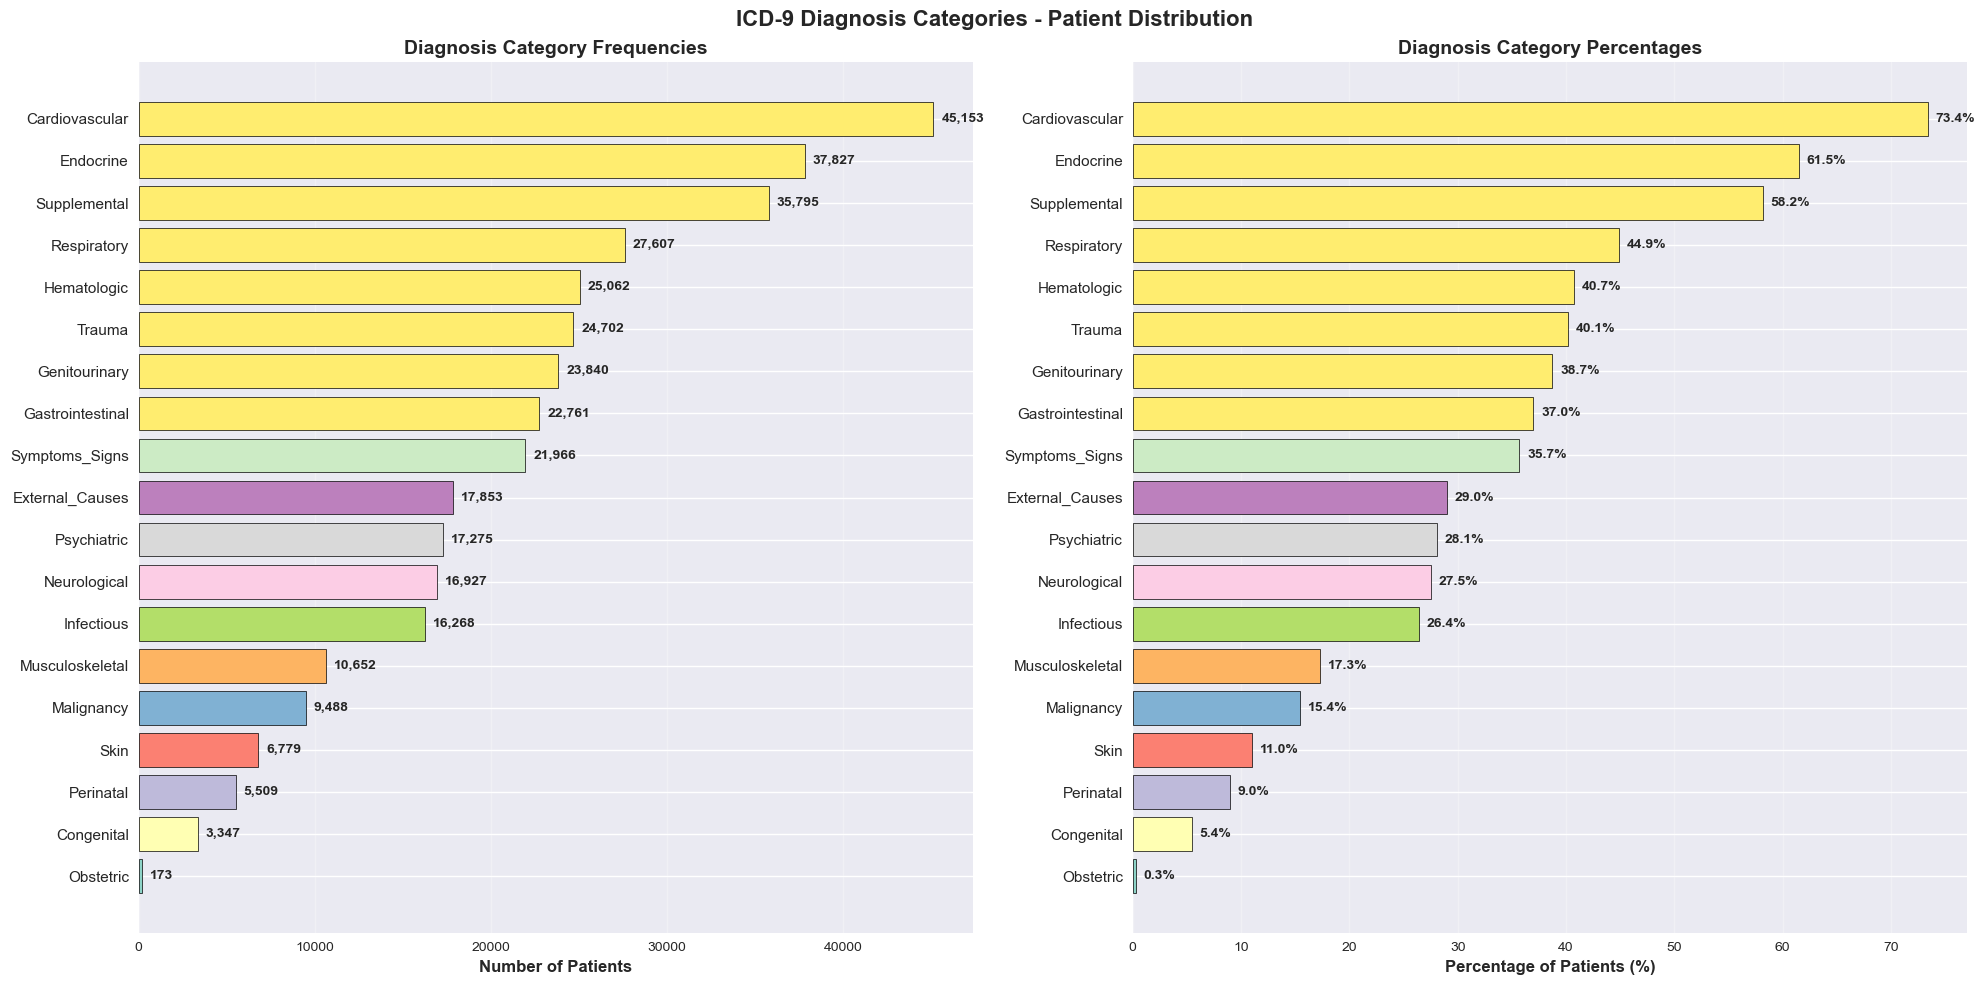


DIAGNOSIS CATEGORY SUMMARY
Total ICU patients analyzed: 61,532
Most common diagnosis category: Cardiovascular (73.4%)
Least common diagnosis category: Obstetric (0.3%)
Average patients per category: 19420
Median patients per category: 17853

Top 5 Most Common Categories:
  Hematologic: 25,062 patients (40.7%)
  Respiratory: 27,607 patients (44.9%)
  Supplemental: 35,795 patients (58.2%)
  Endocrine: 37,827 patients (61.5%)
  Cardiovascular: 45,153 patients (73.4%)

Bottom 5 Least Common Categories:
  Obstetric: 173 patients (0.3%)
  Congenital: 3,347 patients (5.4%)
  Perinatal: 5,509 patients (9.0%)
  Skin: 6,779 patients (11.0%)
  Malignancy: 9,488 patients (15.4%)


In [37]:
cateogry_data_fixed = visualize_diagnosis_categories(diagnosis_bins_patient_fixed)

In [38]:
#summary_table = create_diagnosis_summary_table(diagnosis_bins_patient)

In [39]:
#diagnosis_bins_patient_fixed.show(5)

In [40]:
#diagnosis_bins_patient_fixed.count()

<b> CHART EVENTS and D_ITEMS join </b>

In [41]:
#chart_events_df.show(5)

In [42]:
#d_items_df.show(5)

<b> Check different databases for ChartEvents </b>

In [43]:
#d_items_df.select("DBSOURCE").distinct().show()

In [44]:
chartevents_item_d_items = chart_events_df.join(d_items_df, on=["ITEMID"], how="left")

In [45]:
#chartevents_item_d_items.count()

<b> Generate Avg, std dev, min and max of certain vitals for the first 24hours in ICU </b>

In [46]:
from pyspark.sql.functions import col, avg, when, unix_timestamp, expr, count, min as spark_min, max as spark_max, stddev
from pyspark.sql.types import DoubleType

def extract_vital_signs_first_24h(chartevents_item_d_items, icustays_df):
    """
    Extract average vital signs for the first 24 hours of each ICU stay.
    
    Args:
        chartevents_item_d_items: DataFrame with chartevents joined with d_items
        icustays_df: DataFrame with ICU stay information (for INTIME)
    
    Returns:
        DataFrame with vital signs averages as columns
    """
    
    print("Extracting vital signs for first 24 hours...")
    
    # Define the vital signs we want to extract
    vital_signs = {
        'heart_rate': 211,
        'respiratory_rate': 618,
        'spo2': 646
    }
    
    # First, join chartevents with icustays to get INTIME for each ICU stay
    chartevents_with_intime = chartevents_item_d_items.join(
        icustays_df.select("ICUSTAY_ID", "INTIME"), 
        on="ICUSTAY_ID", 
        how="inner"
    )
    
    # Filter to first 24 hours and specific vital signs
    # Calculate hours from ICU admission
    first_24h_vitals = chartevents_with_intime.filter(
        col("ICUSTAY_ID").isNotNull() &
        col("VALUENUM").isNotNull() &
        col("ITEMID").isin(list(vital_signs.values()))
    ).withColumn(
        "hours_from_intime", 
        (unix_timestamp(col("CHARTTIME")) - unix_timestamp(col("INTIME"))) / 3600
    ).filter(
        (col("hours_from_intime") >= 0) & (col("hours_from_intime") <= 24)
    )
    
    # Create individual DataFrames for each vital sign
    vital_dfs = {}
    
    for vital_name, itemid in vital_signs.items():
        print(f"Processing {vital_name} (ITEMID: {itemid})...")
        
        # Filter for specific vital sign
        vital_df = first_24h_vitals.filter(col("ITEMID") == itemid)
        
        # Calculate statistics for each ICU stay
        vital_stats = vital_df.groupBy("ICUSTAY_ID").agg(
            avg("VALUENUM").alias(f"{vital_name}_avg"),
            spark_min("VALUENUM").alias(f"{vital_name}_min"),
            spark_max("VALUENUM").alias(f"{vital_name}_max"),
            stddev("VALUENUM").alias(f"{vital_name}_std"),
            count("VALUENUM").alias(f"{vital_name}_count")
        )
        
        vital_dfs[vital_name] = vital_stats
        
        # Show some stats
        total_records = vital_df.count()
        unique_icu_stays = vital_df.select("ICUSTAY_ID").distinct().count()
        print(f"  {vital_name}: {total_records:,} measurements across {unique_icu_stays:,} ICU stays")
    
    # Start with base ICU stays
    base_icu_stays = icustays_df.select("ICUSTAY_ID")
    result_df = base_icu_stays
    
    # Join all vital signs statistics
    for vital_name, vital_df in vital_dfs.items():
        result_df = result_df.join(vital_df, on="ICUSTAY_ID", how="left")
    
    # Fill null values with appropriate defaults
    # For averages and stats, we'll leave as null (indicates no data)
    # For counts, we'll fill with 0
    count_columns = [f"{vital}_count" for vital in vital_signs.keys()]
    
    for col_name in count_columns:
        result_df = result_df.withColumn(
            col_name, 
            when(col(col_name).isNull(), 0).otherwise(col(col_name))
        )
    
    print(f"\nVital signs extraction completed!")
    print(f"Result DataFrame shape: {result_df.count():,} ICU stays")
    
    return result_df

def extract_comprehensive_vital_signs_first_24h(chartevents_item_d_items, icustays_df):
    """
    More comprehensive version that includes additional statistics and data quality metrics
    """
    
    print("Extracting comprehensive vital signs for first 24 hours...")
    
    # Define the vital signs we want to extract
    vital_signs = {
        'heart_rate': 211,
        'respiratory_rate': 618,
        'spo2': 646
    }
    
    # Join chartevents with icustays to get INTIME
    chartevents_with_intime = chartevents_item_d_items.join(
        icustays_df.select("ICUSTAY_ID", "INTIME"), 
        on="ICUSTAY_ID", 
        how="inner"
    )
    
    # Filter to first 24 hours and specific vital signs
    first_24h_vitals = chartevents_with_intime.filter(
        col("ICUSTAY_ID").isNotNull() &
        col("VALUENUM").isNotNull() &
        col("ITEMID").isin(list(vital_signs.values()))
    ).withColumn(
        "hours_from_intime", 
        (unix_timestamp(col("CHARTTIME")) - unix_timestamp(col("INTIME"))) / 3600
    ).filter(
        (col("hours_from_intime") >= 0) & (col("hours_from_intime") <= 24)
    )
    
    # Create comprehensive statistics for each vital sign
    vital_dfs = {}
    
    for vital_name, itemid in vital_signs.items():
        print(f"Processing {vital_name} (ITEMID: {itemid})...")
        
        # Filter for specific vital sign
        vital_df = first_24h_vitals.filter(col("ITEMID") == itemid)
        
        # Calculate comprehensive statistics
        vital_stats = vital_df.groupBy("ICUSTAY_ID").agg(
            # Central tendency
            avg("VALUENUM").alias(f"{vital_name}_avg"),
            expr(f"percentile_approx(VALUENUM, 0.5)").alias(f"{vital_name}_median"),
            
            # Variability  
            spark_min("VALUENUM").alias(f"{vital_name}_min"),
            spark_max("VALUENUM").alias(f"{vital_name}_max"),
            stddev("VALUENUM").alias(f"{vital_name}_std"),
            
            # Data quality
            count("VALUENUM").alias(f"{vital_name}_count"),
            
            # Time-based features
            spark_min("hours_from_intime").alias(f"{vital_name}_first_measurement_hour"),
            spark_max("hours_from_intime").alias(f"{vital_name}_last_measurement_hour")
        ).withColumn(
            f"{vital_name}_range", 
            col(f"{vital_name}_max") - col(f"{vital_name}_min")
        ).withColumn(
            f"{vital_name}_coefficient_of_variation",
            col(f"{vital_name}_std") / col(f"{vital_name}_avg")
        )
        
        vital_dfs[vital_name] = vital_stats
        
        # Show statistics
        total_records = vital_df.count()
        unique_icu_stays = vital_df.select("ICUSTAY_ID").distinct().count()
        print(f"  {vital_name}: {total_records:,} measurements across {unique_icu_stays:,} ICU stays")
    
    # Join all vital signs
    base_icu_stays = icustays_df.select("ICUSTAY_ID")
    result_df = base_icu_stays
    
    for vital_name, vital_df in vital_dfs.items():
        result_df = result_df.join(vital_df, on="ICUSTAY_ID", how="left")
    
    # Fill count columns with 0 for missing data
    count_columns = [f"{vital}_count" for vital in vital_signs.keys()]
    for col_name in count_columns:
        result_df = result_df.withColumn(
            col_name, 
            when(col(col_name).isNull(), 0).otherwise(col(col_name))
        )
    
    print(f"\nComprehensive vital signs extraction completed!")
    print(f"Result DataFrame shape: {result_df.count():,} ICU stays")
    
    return result_df

def analyze_vital_signs_coverage(vital_signs_df):
    """
    Analyze the coverage and quality of vital signs data
    """
    print("\n" + "="*60)
    print("VITAL SIGNS DATA COVERAGE ANALYSIS")
    print("="*60)
    
    total_icu_stays = vital_signs_df.count()
    
    vital_signs = ['heart_rate', 'respiratory_rate', 'spo2']
    
    for vital in vital_signs:
        # Count ICU stays with data for this vital
        with_data = vital_signs_df.filter(col(f"{vital}_count") > 0).count()
        coverage_pct = (with_data / total_icu_stays) * 100
        
        # Get average number of measurements
        avg_measurements = vital_signs_df.filter(col(f"{vital}_count") > 0) \
            .agg(avg(f"{vital}_count")).collect()[0][0]
        
        print(f"\n{vital.replace('_', ' ').title()}:")
        print(f"  ICU stays with data: {with_data:,} / {total_icu_stays:,} ({coverage_pct:.1f}%)")
        if avg_measurements:
            print(f"  Average measurements per ICU stay: {avg_measurements:.1f}")
    
    return vital_signs_df


vital_signs_basic = extract_vital_signs_first_24h(chartevents_item_d_items, icustays_df)
    
    # Comprehensive extraction (with additional statistics)
    # vital_signs_comprehensive = extract_comprehensive_vital_signs_first_24h(chartevents_item_d_items, icustays_df)
    
    # Analyze coverage
    # analyze_vital_signs_coverage(vital_signs_basic)

Extracting vital signs for first 24 hours...
Processing heart_rate (ITEMID: 211)...


  heart_rate: 941,857 measurements across 35,719 ICU stays
Processing respiratory_rate (ITEMID: 618)...


  respiratory_rate: 811,142 measurements across 28,874 ICU stays
Processing spo2 (ITEMID: 646)...


  spo2: 808,199 measurements across 28,925 ICU stays

Vital signs extraction completed!


Result DataFrame shape: 61,532 ICU stays


In [47]:
#vital_signs_basic.show(5)

In [48]:
#vital_signs_basic.count()

In [49]:
final_df = diagnosis_bins_patient_fixed.join(vital_signs_basic, how="left", on="ICUSTAY_ID")

In [50]:
#final_df.count()

In [51]:
#final_df.show(5)

In [52]:
from pyspark.sql.functions import col, when, datediff, round as spark_round, year, months_between

def calculate_age_at_admission(df):
    """
    Calculate age at admission for MIMIC-III data.
    
    Important: MIMIC-III has shifted dates for privacy:
    - Patients > 89 years have DOB shifted to year 2100+ 
    - Real ages > 89 appear as 200+ and need to be capped at 90
    
    Args:
        df: DataFrame with DOB and ADMITTIME columns
    
    Returns:
        DataFrame with age_at_admission column added
    """
    
    print("Calculating age at admission...")
    
    # Method 1: Using months_between (most accurate)
    df_with_age = df.withColumn(
        "age_years_raw",
        months_between(col("ADMITTIME"), col("DOB")) / 12
    )
    
    # Handle MIMIC-III age shifting for patients > 89
    # If calculated age > 150, it means the patient was > 89 and DOB was shifted
    df_with_age = df_with_age.withColumn(
        "age_at_admission",
        when(col("age_years_raw") > 150, 90.0)  # Cap at 90 for privacy
        .otherwise(spark_round(col("age_years_raw"), 1))
    )
    
    # Drop the intermediate column
    df_with_age = df_with_age.drop("age_years_raw")
    
    print("Age calculation completed!")
    return df_with_age

def calculate_age_with_validation(df):
    """
    Calculate age with additional validation and statistics
    """
    
    print("Calculating age with validation...")
    
    # Calculate raw age in years (with decimal precision)
    df_with_age = df.withColumn(
        "age_years_raw",
        months_between(col("ADMITTIME"), col("DOB")) / 12
    )
    
    # Create age categories and handle MIMIC-III privacy adjustments
    df_with_age = df_with_age.withColumn(
        "age_at_admission",
        when(col("age_years_raw") > 150, 90.0)  # Patients > 89 (privacy shifted)
        .when(col("age_years_raw") < 0, None)   # Invalid dates
        .otherwise(spark_round(col("age_years_raw"), 1))
    ).withColumn(
        "age_group",
        when(col("age_at_admission") < 18, "Pediatric")
        .when(col("age_at_admission") < 65, "Adult") 
        .when(col("age_at_admission") < 80, "Elderly")
        .when(col("age_at_admission") >= 80, "Very Elderly")
        .otherwise("Unknown")
    ).withColumn(
        "is_elderly", 
        when(col("age_at_admission") >= 65, 1).otherwise(0)
    )
    
    # Drop intermediate column
    df_with_age = df_with_age.drop("age_years_raw")
    
    print("Age calculation with validation completed!")
    return df_with_age

def analyze_age_distribution(df_with_age):
    """
    Analyze the age distribution in the dataset
    """
    print("\n" + "="*50)
    print("AGE DISTRIBUTION ANALYSIS")
    print("="*50)
    
    # Basic age statistics
    age_stats = df_with_age.select("age_at_admission").describe()
    print("\nAge Statistics:")
    age_stats.show()
    
    # Age group distribution
    age_group_dist = df_with_age.groupBy("age_group").count().orderBy("count", ascending=False)
    print("\nAge Group Distribution:")
    age_group_dist.show()
    
    # Elderly vs non-elderly
    elderly_dist = df_with_age.groupBy("is_elderly").count()
    print("\nElderly Distribution (65+ years):")
    elderly_dist.show()
    
    # Check for privacy-shifted patients (age = 90)
    privacy_shifted = df_with_age.filter(col("age_at_admission") == 90.0).count()
    total_patients = df_with_age.count()
    print(f"\nPrivacy-shifted patients (age capped at 90): {privacy_shifted:,} / {total_patients:,} ({privacy_shifted/total_patients*100:.1f}%)")
    
    return df_with_age

def create_age_features(df_with_age):
    """
    Create additional age-related features for modeling
    """
    
    print("Creating additional age features...")
    
    df_enhanced = df_with_age.withColumn(
        "age_squared", 
        col("age_at_admission") * col("age_at_admission")
    ).withColumn(
        "age_decades",
        spark_round(col("age_at_admission") / 10, 0) * 10
    ).withColumn(
        "is_very_young", 
        when(col("age_at_admission") < 30, 1).otherwise(0)
    ).withColumn(
        "is_middle_aged",
        when((col("age_at_admission") >= 30) & (col("age_at_admission") < 65), 1).otherwise(0)
    ).withColumn(
        "is_geriatric",
        when(col("age_at_admission") >= 80, 1).otherwise(0)
    )
    
    print("Enhanced age features created!")
    return df_enhanced

# Example usage and validation
def example_age_calculation():
    """
    Example showing age calculation with sample data
    """
    
    # Your example data
    print("Example calculation:")
    print("DOB: 2101-12-25 00:00:00")
    print("ADMITTIME: 2157-12-03 04:14:00")
    
    # This would calculate to ~56 years in normal circumstances
    # But in MIMIC-III, dates from year 2100+ indicate shifted dates for privacy
    
    from datetime import datetime
    
    # Manual calculation for demonstration
    dob = datetime(2101, 12, 25)
    admittime = datetime(2157, 12, 3)
    
    # Raw calculation (this is what you'd get without privacy adjustment)
    raw_age = (admittime - dob).days / 365.25
    print(f"Raw calculated age: {raw_age:.1f} years")
    
    # In MIMIC-III, this indicates the patient was actually > 89 years old
    # So we would cap it at 90
    adjusted_age = 90.0 if raw_age > 150 else raw_age
    print(f"MIMIC-III adjusted age: {adjusted_age:.1f} years")

<b> Probably best dataframe for EDA </b>

In [53]:
final_df_with_age = calculate_age_at_admission(final_df)

Calculating age at admission...
Age calculation completed!


In [54]:
final_df_with_age.show(5) 

+----------+----------+-------+----------+--------------+-------------+------------+-----------+-------------------+-------------------+-------+-------------------+-------------------+---------+--------------+--------------------+------------------+---------+--------+-------------+--------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+------+-------------------+----+-----------+--------------+--------------+-------------+---------------+---------------+----------------+------------------+---------------+--------------------+-----------------+-------------+--------+-------------------+--------------+-------------+------------------+----------+-------------------+----------------+---------------+-----------------+--------------+--------------+------------------+----------------+--------------------+--------------------+--------------------+--------------------+----------------------+-----------------+----

In [70]:
exc_columns=["HOSPITAL_EXPIRE_FLAG","MARITAL_STATUS","SUBJECT_ID","HADM_ID", "DBSOURCE", "FIRST_CAREUNIT","LAST_CAREUNIT","FIRST_WARDID", "LAST_WARDID","INTIME","OUTTIME","ADMITTIME","DISCHTIME", "DEATHTIME","ADMISSION_TYPE","ADMISSION_LOCATION","DISCHARGE_LOCATION","INSURANCE","LANGUAGE","RELIGION","ETHNICITY", "EDREGTIME", "EDOUTTIME", "HAS_CHARTEVENTS_DATA", "DOB", "DOD"]
final_df_with_age = final_df_with_age.drop(*exc_columns)

In [71]:
cols = final_df_with_age.columns

In [72]:
len(cols)

41

In [73]:
print(cols)

['ICUSTAY_ID', 'LOS', 'DIAGNOSIS', 'GENDER', 'EXPIRE_FLAG', 'has_infectious', 'has_malignancy', 'has_endocrine', 'has_hematologic', 'has_psychiatric', 'has_neurological', 'has_cardiovascular', 'has_respiratory', 'has_gastrointestinal', 'has_genitourinary', 'has_obstetric', 'has_skin', 'has_musculoskeletal', 'has_congenital', 'has_perinatal', 'has_symptoms_signs', 'has_trauma', 'has_external_causes', 'has_supplemental', 'total_diagnoses', 'heart_rate_avg', 'heart_rate_min', 'heart_rate_max', 'heart_rate_std', 'heart_rate_count', 'respiratory_rate_avg', 'respiratory_rate_min', 'respiratory_rate_max', 'respiratory_rate_std', 'respiratory_rate_count', 'spo2_avg', 'spo2_min', 'spo2_max', 'spo2_std', 'spo2_count', 'age_at_admission']


In [55]:
#len(final_df_with_age.columns)

In [56]:
#df_cols = final_df_with_age.columns

In [57]:
#print(df_cols)

#### <b> Machine Learning </b>

In [85]:
def convert_spark_to_pandas(spark_df):
    """
    Convert PySpark DataFrame to pandas DataFrame with progress info
    """
    print("="*60)
    print("CONVERTING PYSPARK TO PANDAS")
    print("="*60)
    
    print("Converting PySpark DataFrame to pandas...")
    pandas_df = spark_df.toPandas()
    
    print(f"✅ Conversion successful!")
    print(f"   Dataset shape: {pandas_df.shape}")
    print(f"   Memory usage: {pandas_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    print(f"   Columns: {list(pandas_df.columns[:5])}{'...' if len(pandas_df.columns) > 5 else ''}")
    
    return pandas_df

In [86]:
def analyze_missing_data(df):
    """
    Comprehensive analysis of missing data patterns
    """
    print("\n" + "="*60)
    print("MISSING DATA ANALYSIS")
    print("="*60)
    
    # Calculate missing percentages
    missing_stats = []
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_pct = (missing_count / len(df)) * 100
        missing_stats.append({
            'column': col,
            'missing_count': missing_count,
            'missing_percentage': missing_pct,
            'data_type': str(df[col].dtype)
        })
    
    missing_df = pd.DataFrame(missing_stats).sort_values('missing_percentage', ascending=False)
    
    # Show columns with missing data
    missing_cols = missing_df[missing_df['missing_percentage'] > 0]
    if len(missing_cols) > 0:
        print("Columns with missing data:")
        for _, row in missing_cols.head(15).iterrows():
            print(f"  {row['column']}: {row['missing_count']:,} ({row['missing_percentage']:.1f}%)")
    else:
        print("No missing data found!")
    
    return missing_df


In [87]:
def preprocess_for_ml(df):
    """
    Simple preprocessing pipeline for ICU LOS prediction
    """
    print("\n" + "="*60)
    print("ML PREPROCESSING PIPELINE")
    print("="*60)
    
    # Make a copy to avoid modifying original
    df_processed = df.copy()
    
    # 1. BASIC DATA CLEANING
    print("\n1. Basic Data Cleaning...")
    
    # Remove rows with missing target variable
    initial_count = len(df_processed)
    df_processed = df_processed.dropna(subset=['LOS'])
    df_processed = df_processed[df_processed['LOS'] > 0]  # Remove invalid LOS
    print(f"   Removed {initial_count - len(df_processed):,} rows with invalid LOS")
    
    # Remove extreme outliers (LOS > 30 days is very rare)
    outlier_threshold = 30
    outliers = df_processed[df_processed['LOS'] > outlier_threshold]
    df_processed = df_processed[df_processed['LOS'] <= outlier_threshold]
    print(f"   Removed {len(outliers):,} outliers (LOS > {outlier_threshold} days)")
    
    print(f"   Final dataset size: {len(df_processed):,} records")
    
    # 2. FEATURE SELECTION
    print("\n2. Feature Selection...")
    
    # Define feature groups - check which ones exist in the dataset
    demographic_features = ['GENDER', 'age_at_admission']
    
    administrative_features = ['ADMISSION_TYPE', 'FIRST_CAREUNIT', 'INSURANCE']
    
    diagnosis_features = [
        'has_infectious', 'has_malignancy', 'has_endocrine', 'has_hematologic',
        'has_psychiatric', 'has_neurological', 'has_cardiovascular', 'has_respiratory',
        'has_gastrointestinal', 'has_genitourinary', 'has_obstetric', 'has_skin',
        'has_musculoskeletal', 'has_congenital', 'has_perinatal', 'has_symptoms_signs',
        'has_trauma', 'has_external_causes', 'has_supplemental', 'total_diagnoses'
    ]
    
    vital_features = [
        'heart_rate_avg', 'heart_rate_min', 'heart_rate_max', 'heart_rate_std', 'heart_rate_count',
        'respiratory_rate_avg', 'respiratory_rate_min', 'respiratory_rate_max', 'respiratory_rate_std', 'respiratory_rate_count',
        'spo2_avg', 'spo2_min', 'spo2_max', 'spo2_std', 'spo2_count'
    ]
    
    # Keep only features that exist in the dataset
    all_features = demographic_features + administrative_features + diagnosis_features + vital_features
    available_features = [f for f in all_features if f in df_processed.columns]
    
    # Show which features are available vs missing
    missing_features = [f for f in all_features if f not in df_processed.columns]
    print(f"   Available features: {len(available_features)}")
    if missing_features:
        print(f"   Missing features: {len(missing_features)} - {missing_features[:5]}{'...' if len(missing_features) > 5 else ''}")
    
    # Select features + target
    feature_cols = available_features
    target_col = 'LOS'
    
    if target_col not in df_processed.columns:
        raise ValueError(f"Target column '{target_col}' not found in dataset!")
    
    df_ml = df_processed[feature_cols + [target_col]].copy()
    print(f"   Selected {len(feature_cols)} features for modeling")
    
    # 3. MISSING DATA HANDLING
    print("\n3. Missing Data Handling...")
    
    # Separate categorical and numerical features
    categorical_features = []
    numerical_features = []
    
    for col in feature_cols:
        if df_ml[col].dtype == 'object' or col.startswith('has_'):
            categorical_features.append(col)
        else:
            numerical_features.append(col)
    
    print(f"   Categorical features: {len(categorical_features)}")
    print(f"   Numerical features: {len(numerical_features)}")
    
    # Handle missing values in categorical features
    for col in categorical_features:
        if df_ml[col].isnull().sum() > 0:
            # Fill with mode (most frequent value)
            mode_value = df_ml[col].mode().iloc[0] if len(df_ml[col].mode()) > 0 else 'Unknown'
            df_ml[col] = df_ml[col].fillna(mode_value)
            print(f"   Filled {col} missing values with: {mode_value}")
    
    # Handle missing values in numerical features
    vital_signs_cols = [col for col in numerical_features if any(vs in col for vs in ['heart_rate', 'respiratory_rate', 'spo2'])]
    other_numerical = [col for col in numerical_features if col not in vital_signs_cols]
    
    # For vital signs: Use median imputation or 0 for counts
    for col in vital_signs_cols:
        if df_ml[col].isnull().sum() > 0:
            if 'count' in col:
                df_ml[col] = df_ml[col].fillna(0)
                print(f"   Filled {col} missing values with 0")
            else:
                median_val = df_ml[col].median()
                df_ml[col] = df_ml[col].fillna(median_val)
                print(f"   Filled {col} missing values with median: {median_val:.2f}")
    
    # For other numerical: Use median imputation
    for col in other_numerical:
        if df_ml[col].isnull().sum() > 0:
            median_val = df_ml[col].median()
            df_ml[col] = df_ml[col].fillna(median_val)
            print(f"   Filled {col} missing values with median: {median_val:.2f}")
    
    # 4. CATEGORICAL ENCODING
    print("\n4. Categorical Encoding...")
    
    # Handle categorical variables (exclude binary diagnosis features)
    categorical_to_encode = [col for col in categorical_features if not col.startswith('has_')]
    
    # One-hot encode categorical variables
    if categorical_to_encode:
        df_encoded = pd.get_dummies(df_ml, columns=categorical_to_encode, prefix=categorical_to_encode)
        print(f"   One-hot encoded {len(categorical_to_encode)} categorical features")
        print(f"   New feature count: {len(df_encoded.columns) - 1}")  # -1 for target
    else:
        df_encoded = df_ml.copy()
        print("   No categorical features to encode")
    
    # 5. FINAL PREPARATION
    print("\n5. Final Preparation...")
    
    # Separate features and target
    X = df_encoded.drop(columns=[target_col])
    y = df_encoded[target_col]
    
    print(f"   Final feature matrix shape: {X.shape}")
    print(f"   Target variable shape: {y.shape}")
    print(f"   Target variable stats: Mean={y.mean():.2f}, Std={y.std():.2f}, Min={y.min():.2f}, Max={y.max():.2f}")
    
    return X, y, df_encoded

In [88]:
def plot_cv_results(cv_results_df):
    """
    Plot cross-validation results with error bars
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    models = cv_results_df['Model']
    
    # RMSE plot
    axes[0].bar(models, cv_results_df['CV_RMSE_Mean'], 
                yerr=cv_results_df['CV_RMSE_Std'], capsize=5, alpha=0.7, color='skyblue')
    axes[0].set_title('Cross-Validation RMSE')
    axes[0].set_ylabel('RMSE (days)')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(alpha=0.3)
    
    # MAE plot  
    axes[1].bar(models, cv_results_df['CV_MAE_Mean'],
                yerr=cv_results_df['CV_MAE_Std'], capsize=5, alpha=0.7, color='lightgreen')
    axes[1].set_title('Cross-Validation MAE')
    axes[1].set_ylabel('MAE (days)')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(alpha=0.3)
    
    # R² plot
    axes[2].bar(models, cv_results_df['CV_R2_Mean'],
                yerr=cv_results_df['CV_R2_Std'], capsize=5, alpha=0.7, color='lightcoral')
    axes[2].set_title('Cross-Validation R²')
    axes[2].set_ylabel('R²')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_feature_importance(models, X):
    """
    Analyze feature importance from tree-based models
    """
    feature_names = X.columns if hasattr(X, 'columns') else [f'feature_{i}' for i in range(X.shape[1])]
    
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    
    # Get feature importance from Random Forest
    if 'Random Forest' in models:
        rf_model = models['Random Forest']
        importance_scores = rf_model.feature_importances_
        
        # Create importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance_scores
        }).sort_values('importance', ascending=False)
        
        print("\nTop 15 Most Important Features (Random Forest):")
        for i, row in importance_df.head(15).iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title('Top 15 Feature Importance (Random Forest)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        return importance_df
    
    return None

In [89]:
def create_baseline_models_with_cv(X, y):
    """
    Create and evaluate baseline models with cross-validation
    """
    print("\n" + "="*60)
    print("BASELINE MODEL EVALUATION WITH CROSS-VALIDATION")
    print("="*60)
    
    # Split the data for final holdout test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features for Linear Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define cross-validation strategy
    cv_folds = 5
    kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Custom scorer for RMSE
    rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
    
    # Define models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    cv_results = []
    final_results = []
    trained_models = {}
    
    # Cross-validation for models
    for name, model in models.items():
        print(f"\nEvaluating {name} with {cv_folds}-fold Cross-Validation...")
        
        # Choose appropriate data for CV
        if name == 'Linear Regression':
            X_cv = X_train_scaled
            X_final_test = X_test_scaled
        else:
            X_cv = X_train
            X_final_test = X_test
        
        # Perform cross-validation
        cv_rmse_scores = -cross_val_score(model, X_cv, y_train, cv=kfold, scoring=rmse_scorer)
        cv_mae_scores = -cross_val_score(model, X_cv, y_train, cv=kfold, scoring='neg_mean_absolute_error')
        cv_r2_scores = cross_val_score(model, X_cv, y_train, cv=kfold, scoring='r2')
        
        print(f"   CV RMSE: {cv_rmse_scores.mean():.3f} ± {cv_rmse_scores.std():.3f}")
        print(f"   CV MAE:  {cv_mae_scores.mean():.3f} ± {cv_mae_scores.std():.3f}")
        print(f"   CV R²:   {cv_r2_scores.mean():.3f} ± {cv_r2_scores.std():.3f}")
        
        # Store CV results
        cv_results.append({
            'Model': name,
            'CV_RMSE_Mean': cv_rmse_scores.mean(),
            'CV_RMSE_Std': cv_rmse_scores.std(),
            'CV_MAE_Mean': cv_mae_scores.mean(),
            'CV_MAE_Std': cv_mae_scores.std(),
            'CV_R2_Mean': cv_r2_scores.mean(),
            'CV_R2_Std': cv_r2_scores.std()
        })
        
        # Train on full training set and evaluate on test set
        model.fit(X_cv, y_train)
        y_pred = model.predict(X_final_test)
        
        # Calculate final test metrics
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_mae = mean_absolute_error(y_test, y_pred)
        test_r2 = r2_score(y_test, y_pred)
        
        print(f"   Test RMSE: {test_rmse:.3f}")
        print(f"   Test MAE:  {test_mae:.3f}")
        print(f"   Test R²:   {test_r2:.3f}")
        
        final_results.append({
            'Model': name,
            'Test_RMSE': test_rmse,
            'Test_MAE': test_mae,
            'Test_R2': test_r2
        })
        
        # Store trained model
        trained_models[name] = model
    
    # Create results DataFrames
    cv_results_df = pd.DataFrame(cv_results).sort_values('CV_RMSE_Mean')
    final_results_df = pd.DataFrame(final_results).sort_values('Test_RMSE')
    
    print(f"\n" + "="*60)
    print("CROSS-VALIDATION RESULTS")
    print("="*60)
    print(cv_results_df.to_string(index=False, float_format='%.3f'))
    
    print(f"\n" + "="*60)
    print("FINAL TEST SET RESULTS")
    print("="*60)
    print(final_results_df.to_string(index=False, float_format='%.3f'))
    
    # Plot CV results
    plot_cv_results(cv_results_df)
    
    return cv_results_df, final_results_df, trained_models, scaler, X_train, X_test, y_train, y_test

    

🔥 PANDAS ML PIPELINE FOR ICU LOS PREDICTION
Ready to use! Choose one of these options:

🚀 OPTION 1: Run complete pipeline (recommended)
🚀 STARTING COMPLETE ICU LOS PREDICTION PIPELINE
CONVERTING PYSPARK TO PANDAS
Converting PySpark DataFrame to pandas...


✅ Conversion successful!
   Dataset shape: (61532, 41)
   Memory usage: 20.4 MB
   Columns: ['ICUSTAY_ID', 'LOS', 'DIAGNOSIS', 'GENDER', 'EXPIRE_FLAG']...

MISSING DATA ANALYSIS
Columns with missing data:
  respiratory_rate_std: 32,719 (53.2%)
  respiratory_rate_max: 32,658 (53.1%)
  respiratory_rate_avg: 32,658 (53.1%)
  respiratory_rate_min: 32,658 (53.1%)
  spo2_std: 32,649 (53.1%)
  spo2_max: 32,607 (53.0%)
  spo2_min: 32,607 (53.0%)
  spo2_avg: 32,607 (53.0%)
  heart_rate_std: 27,266 (44.3%)
  heart_rate_avg: 25,813 (42.0%)
  heart_rate_min: 25,813 (42.0%)
  heart_rate_max: 25,813 (42.0%)
  LOS: 10 (0.0%)
  DIAGNOSIS: 1 (0.0%)

ML PREPROCESSING PIPELINE

1. Basic Data Cleaning...
   Removed 10 rows with invalid LOS
   Removed 1,446 outliers (LOS > 30 days)
   Final dataset size: 60,076 records

2. Feature Selection...
   Available features: 37
   Missing features: 3 - ['ADMISSION_TYPE', 'FIRST_CAREUNIT', 'INSURANCE']
   Selected 37 features for modeling

3. Missing Data Handling..

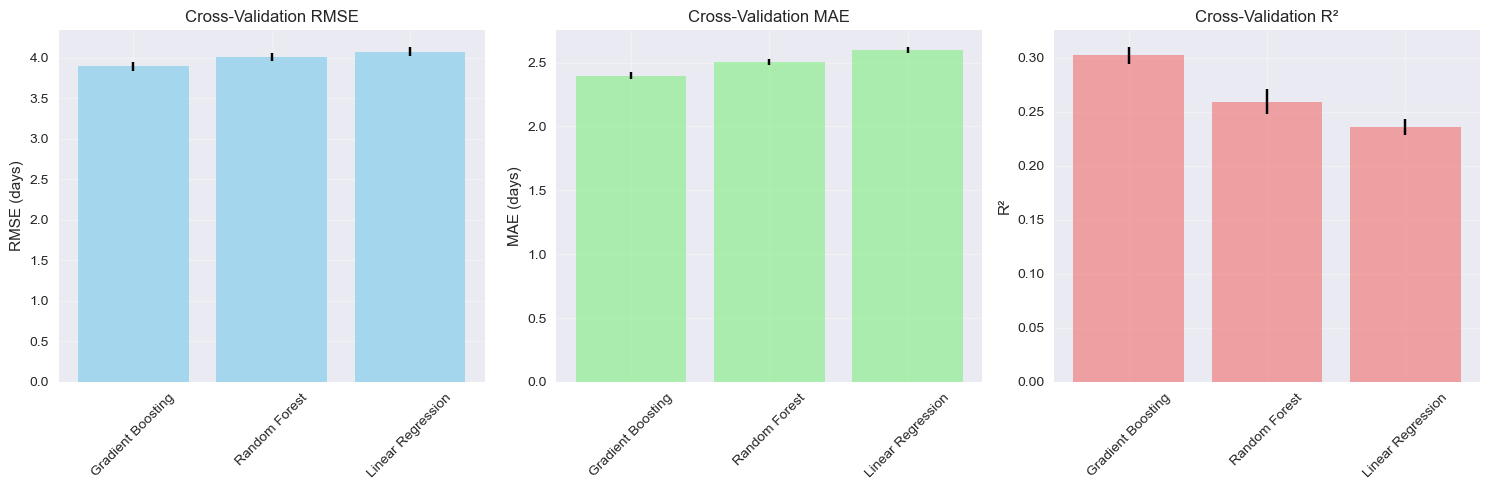


FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features (Random Forest):
  age_at_admission: 0.1194
  total_diagnoses: 0.1162
  heart_rate_count: 0.0830
  has_respiratory: 0.0711
  heart_rate_avg: 0.0640
  heart_rate_min: 0.0556
  heart_rate_std: 0.0451
  heart_rate_max: 0.0362
  respiratory_rate_std: 0.0350
  spo2_count: 0.0297
  respiratory_rate_avg: 0.0289
  spo2_avg: 0.0271
  spo2_std: 0.0255
  respiratory_rate_max: 0.0169
  respiratory_rate_min: 0.0159


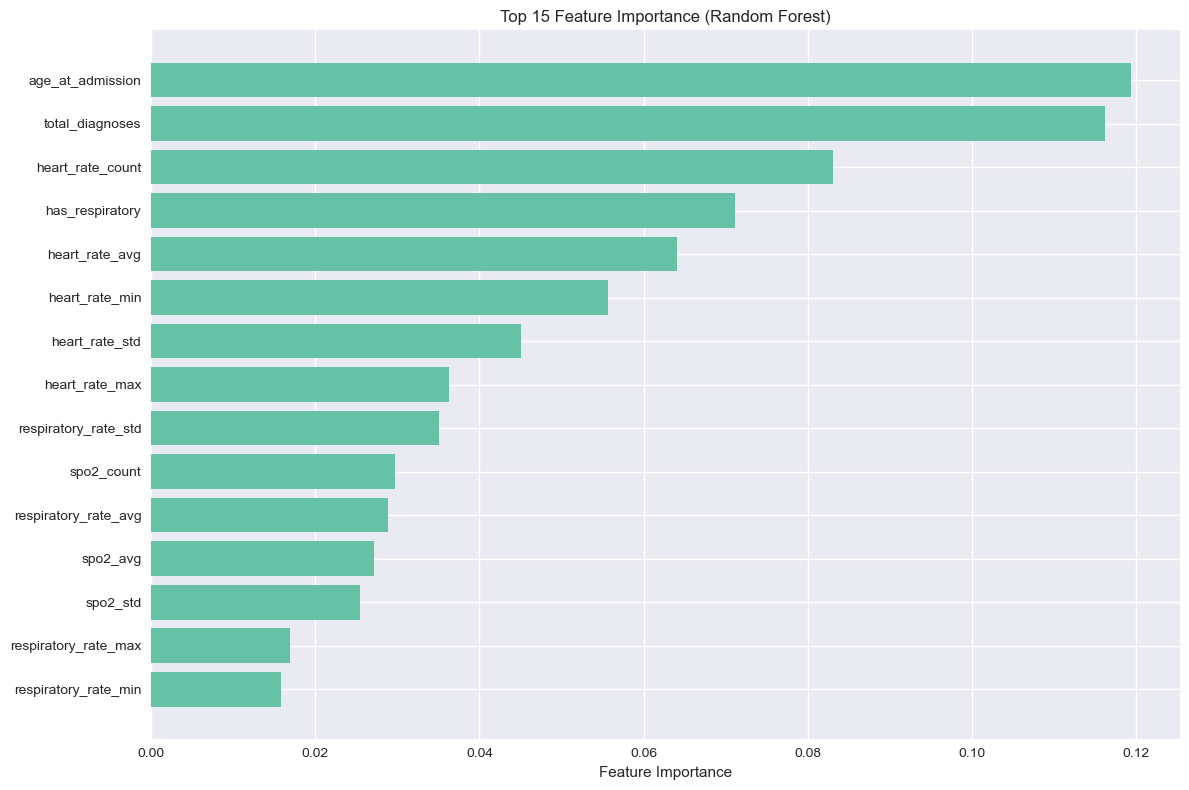


🎉 PIPELINE COMPLETE!
✅ Dataset processed: 61,532 -> 60,076 records
✅ Features used: 38
✅ Best model: Gradient Boosting (RMSE: 3.974)


'\nprint()\nprint("🔧 OPTION 2: Step by step")\nprint("   df = convert_spark_to_pandas(final_df_with_age)")\nprint("   missing_analysis = analyze_missing_data(df)")\nprint("   X, y, df_processed = preprocess_for_ml(df)")\nprint("   cv_results, final_results, models, scaler, X_train, X_test, y_train, y_test = create_baseline_models_with_cv(X, y)")\nprint("   feature_importance = analyze_feature_importance(models, X)")\nprint()\nprint("📊 OPTION 3: Quick conversion only")\nprint("   df_pandas = convert_spark_to_pandas(final_df_with_age)")\n'

In [90]:

def run_complete_pipeline(spark_df):
    """
    Run the complete ML pipeline: Convert PySpark -> Preprocess -> Train -> Evaluate
    """
    print("🚀 STARTING COMPLETE ICU LOS PREDICTION PIPELINE")
    print("="*80)
    
    # Step 1: Convert PySpark to pandas
    df = convert_spark_to_pandas(spark_df)
    
    # Step 2: Analyze missing data
    missing_analysis = analyze_missing_data(df)
    
    # Step 3: Preprocess data
    X, y, df_processed = preprocess_for_ml(df)
    
    # Step 4: Create and evaluate models
    cv_results, final_results, models, scaler, X_train, X_test, y_train, y_test = create_baseline_models_with_cv(X, y)
    
    # Step 5: Analyze feature importance
    feature_importance = analyze_feature_importance(models, X)
    
    print("\n" + "="*80)
    print("🎉 PIPELINE COMPLETE!")
    print("="*80)
    print(f"✅ Dataset processed: {len(df):,} -> {len(df_processed):,} records")
    print(f"✅ Features used: {X.shape[1]}")
    print(f"✅ Best model: {final_results.iloc[0]['Model']} (RMSE: {final_results.iloc[0]['Test_RMSE']:.3f})")
    
    return {
        'pandas_df': df,
        'missing_analysis': missing_analysis,
        'processed_data': (X, y, df_processed),
        'cv_results': cv_results,
        'final_results': final_results,
        'trained_models': models,
        'feature_importance': feature_importance,
        'scaler': scaler,
        'train_test_split': (X_train, X_test, y_train, y_test)
    }

# ============================================================================
# USAGE EXAMPLES
# ============================================================================

print("🔥 PANDAS ML PIPELINE FOR ICU LOS PREDICTION")
print("="*80)
print("Ready to use! Choose one of these options:")
print()
print("🚀 OPTION 1: Run complete pipeline (recommended)")
results = run_complete_pipeline(final_df_with_age)
'''
print()
print("🔧 OPTION 2: Step by step")
print("   df = convert_spark_to_pandas(final_df_with_age)")
print("   missing_analysis = analyze_missing_data(df)")
print("   X, y, df_processed = preprocess_for_ml(df)")
print("   cv_results, final_results, models, scaler, X_train, X_test, y_train, y_test = create_baseline_models_with_cv(X, y)")
print("   feature_importance = analyze_feature_importance(models, X)")
print()
print("📊 OPTION 3: Quick conversion only")
print("   df_pandas = convert_spark_to_pandas(final_df_with_age)")
'''

In [76]:
'''
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def convert_spark_to_pandas(spark_df):
    """
    Convert PySpark DataFrame to pandas DataFrame with progress info
    """
    print("="*60)
    print("CONVERTING PYSPARK TO PANDAS")
    print("="*60)
    
    print("Converting PySpark DataFrame to pandas...")
    pandas_df = spark_df.toPandas()
    
    print(f"✅ Conversion successful!")
    print(f"   Dataset shape: {pandas_df.shape}")
    print(f"   Memory usage: {pandas_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    print(f"   Columns: {list(pandas_df.columns[:5])}{'...' if len(pandas_df.columns) > 5 else ''}")
    
    return pandas_df

def analyze_missing_data(df):
    """
    Comprehensive analysis of missing data patterns
    """
    print("\n" + "="*60)
    print("MISSING DATA ANALYSIS")
    print("="*60)
    
    # Calculate missing percentages
    missing_stats = []
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_pct = (missing_count / len(df)) * 100
        missing_stats.append({
            'column': col,
            'missing_count': missing_count,
            'missing_percentage': missing_pct,
            'data_type': str(df[col].dtype)
        })
    
    missing_df = pd.DataFrame(missing_stats).sort_values('missing_percentage', ascending=False)
    
    # Show columns with missing data
    missing_cols = missing_df[missing_df['missing_percentage'] > 0]
    if len(missing_cols) > 0:
        print("Columns with missing data:")
        for _, row in missing_cols.head(15).iterrows():
            print(f"  {row['column']}: {row['missing_count']:,} ({row['missing_percentage']:.1f}%)")
    else:
        print("No missing data found!")
    
    return missing_df

def create_enhanced_features(df):
    """
    Create enhanced features that work with your PySpark data structure
    """
    print("\n" + "="*60)
    print("ENHANCED FEATURE ENGINEERING")
    print("="*60)
    
    df_enhanced = df.copy()
    
    # 1. AGE-BASED FEATURES (using existing age_at_admission)
    if 'age_at_admission' in df_enhanced.columns:
        print("\n1. Age-based features...")
        df_enhanced['age_group'] = pd.cut(df_enhanced['age_at_admission'], 
                                         bins=[0, 18, 35, 50, 65, 80, 120], 
                                         labels=['pediatric', 'young_adult', 'adult', 'middle_aged', 'elderly', 'very_elderly'])
        df_enhanced['is_elderly'] = (df_enhanced['age_at_admission'] >= 65).astype(int)
        df_enhanced['is_pediatric'] = (df_enhanced['age_at_admission'] < 18).astype(int)
        df_enhanced['age_squared'] = df_enhanced['age_at_admission'] ** 2
        df_enhanced['age_log'] = np.log(df_enhanced['age_at_admission'] + 1)
        print(f"   Added 5 age-based features")
    
    # 2. DIAGNOSIS COMPLEXITY FEATURES
    diagnosis_cols = [col for col in df_enhanced.columns if col.startswith('has_')]
    if diagnosis_cols:
        print(f"\n2. Diagnosis complexity features ({len(diagnosis_cols)} diagnosis columns)...")
        
        # Basic complexity
        df_enhanced['diagnosis_count_calculated'] = df_enhanced[diagnosis_cols].sum(axis=1)
        df_enhanced['has_multiple_diagnoses'] = (df_enhanced['diagnosis_count_calculated'] > 1).astype(int)
        df_enhanced['has_complex_case'] = (df_enhanced['diagnosis_count_calculated'] >= 3).astype(int)
        
        # High-risk combinations
        high_risk_conditions = ['has_cardiovascular', 'has_respiratory', 'has_neurological', 'has_malignancy']
        available_high_risk = [col for col in high_risk_conditions if col in df_enhanced.columns]
        if available_high_risk:
            df_enhanced['has_high_risk_condition'] = df_enhanced[available_high_risk].max(axis=1)
            df_enhanced['high_risk_count'] = df_enhanced[available_high_risk].sum(axis=1)
        
        # Weighted diagnosis risk score
        risk_weights = {
            'has_malignancy': 3, 'has_cardiovascular': 2, 'has_respiratory': 2,
            'has_neurological': 2, 'has_trauma': 1.5, 'has_infectious': 1,
            'has_gastrointestinal': 1, 'has_genitourinary': 1
        }
        
        df_enhanced['diagnosis_risk_score'] = 0
        for condition, weight in risk_weights.items():
            if condition in df_enhanced.columns:
                df_enhanced['diagnosis_risk_score'] += df_enhanced[condition] * weight
        
        # Organ system categories
        cardiovascular_conditions = ['has_cardiovascular']
        respiratory_conditions = ['has_respiratory']
        neurological_conditions = ['has_neurological', 'has_psychiatric']
        
        for system, conditions in [('cardiovascular', cardiovascular_conditions), 
                                  ('respiratory', respiratory_conditions),
                                  ('neurological', neurological_conditions)]:
            available_conditions = [c for c in conditions if c in df_enhanced.columns]
            if available_conditions:
                df_enhanced[f'has_{system}_system'] = df_enhanced[available_conditions].max(axis=1)
        
        print(f"   Added diagnosis complexity and risk scoring features")
    
    # 3. VITAL SIGNS ENHANCED FEATURES
    vital_prefixes = ['heart_rate', 'respiratory_rate', 'spo2']
    for prefix in vital_prefixes:
        avg_col = f'{prefix}_avg'
        min_col = f'{prefix}_min'
        max_col = f'{prefix}_max'
        std_col = f'{prefix}_std'
        count_col = f'{prefix}_count'
        
        if all(col in df_enhanced.columns for col in [avg_col, min_col, max_col]):
            print(f"\n3. {prefix.replace('_', ' ').title()} enhanced features...")
            
            # Basic ranges and variability
            df_enhanced[f'{prefix}_range'] = df_enhanced[max_col] - df_enhanced[min_col]
            
            if std_col in df_enhanced.columns:
                df_enhanced[f'{prefix}_cv'] = df_enhanced[std_col] / (df_enhanced[avg_col] + 1e-8)
            
            # Clinical abnormality flags
            if prefix == 'heart_rate':
                df_enhanced[f'{prefix}_abnormal'] = ((df_enhanced[avg_col] < 60) | (df_enhanced[avg_col] > 100)).astype(int)
                df_enhanced[f'{prefix}_very_abnormal'] = ((df_enhanced[avg_col] < 50) | (df_enhanced[avg_col] > 120)).astype(int)
                df_enhanced[f'{prefix}_tachycardia'] = (df_enhanced[avg_col] > 100).astype(int)
                df_enhanced[f'{prefix}_bradycardia'] = (df_enhanced[avg_col] < 60).astype(int)
                df_enhanced[f'{prefix}_severe_tachy'] = (df_enhanced[avg_col] > 120).astype(int)
                df_enhanced[f'{prefix}_severe_brady'] = (df_enhanced[avg_col] < 50).astype(int)
            elif prefix == 'respiratory_rate':
                df_enhanced[f'{prefix}_abnormal'] = ((df_enhanced[avg_col] < 12) | (df_enhanced[avg_col] > 20)).astype(int)
                df_enhanced[f'{prefix}_very_abnormal'] = ((df_enhanced[avg_col] < 10) | (df_enhanced[avg_col] > 25)).astype(int)
                df_enhanced[f'{prefix}_tachypnea'] = (df_enhanced[avg_col] > 20).astype(int)
                df_enhanced[f'{prefix}_bradypnea'] = (df_enhanced[avg_col] < 12).astype(int)
            elif prefix == 'spo2':
                df_enhanced[f'{prefix}_abnormal'] = (df_enhanced[avg_col] < 95).astype(int)
                df_enhanced[f'{prefix}_very_abnormal'] = (df_enhanced[avg_col] < 90).astype(int)
                df_enhanced[f'{prefix}_hypoxic'] = (df_enhanced[avg_col] < 92).astype(int)
                df_enhanced[f'{prefix}_severe_hypoxic'] = (df_enhanced[avg_col] < 88).astype(int)
            
            # Data quality indicators
            if count_col in df_enhanced.columns:
                df_enhanced[f'{prefix}_data_rich'] = (df_enhanced[count_col] > df_enhanced[count_col].median()).astype(int)
                df_enhanced[f'{prefix}_sparse_data'] = (df_enhanced[count_col] < df_enhanced[count_col].quantile(0.25)).astype(int)
            
            print(f"   Added enhanced clinical indicators for {prefix}")
    
    # 4. INTERACTION FEATURES
    print("\n4. Interaction features...")
    
    # Age × Diagnosis interactions
    if 'age_at_admission' in df_enhanced.columns:
        if 'diagnosis_count_calculated' in df_enhanced.columns:
            df_enhanced['age_diagnosis_interaction'] = df_enhanced['age_at_admission'] * df_enhanced['diagnosis_count_calculated']
        if 'diagnosis_risk_score' in df_enhanced.columns:
            df_enhanced['age_risk_interaction'] = df_enhanced['age_at_admission'] * df_enhanced['diagnosis_risk_score']
        if 'has_high_risk_condition' in df_enhanced.columns:
            df_enhanced['elderly_high_risk'] = df_enhanced['is_elderly'] * df_enhanced['has_high_risk_condition']
    
    # Vital signs instability scores
    vital_abnormal_cols = [col for col in df_enhanced.columns if col.endswith('_abnormal') and not col.endswith('_very_abnormal')]
    if vital_abnormal_cols:
        df_enhanced['vital_instability_score'] = df_enhanced[vital_abnormal_cols].sum(axis=1)
        print(f"   Added vital instability score from {len(vital_abnormal_cols)} indicators")
    
    very_abnormal_cols = [col for col in df_enhanced.columns if col.endswith('_very_abnormal')]
    if very_abnormal_cols:
        df_enhanced['severe_instability_score'] = df_enhanced[very_abnormal_cols].sum(axis=1)
        print(f"   Added severe instability score")
    
    # Mortality risk interactions
    if 'EXPIRE_FLAG' in df_enhanced.columns or 'HOSPITAL_EXPIRE_FLAG' in df_enhanced.columns:
        mortality_col = 'EXPIRE_FLAG' if 'EXPIRE_FLAG' in df_enhanced.columns else 'HOSPITAL_EXPIRE_FLAG'
        if 'age_at_admission' in df_enhanced.columns:
            df_enhanced['age_mortality_risk'] = df_enhanced['age_at_admission'] * df_enhanced[mortality_col]
        if 'diagnosis_risk_score' in df_enhanced.columns:
            df_enhanced['diagnosis_mortality_risk'] = df_enhanced['diagnosis_risk_score'] * df_enhanced[mortality_col]
    
    # 5. MARITAL STATUS (if available in PySpark data)
    if 'MARITAL_STATUS' in df_enhanced.columns:
        print("\n5. Social features...")
        df_enhanced['is_married'] = (df_enhanced['MARITAL_STATUS'] == 'MARRIED').astype(int)
        df_enhanced['is_single'] = (df_enhanced['MARITAL_STATUS'] == 'SINGLE').astype(int)
        print("   Added marital status indicators")
    
    print(f"\n✅ Enhanced feature engineering complete!")
    print(f"   Original features: {len(df.columns)}")
    print(f"   Enhanced features: {len(df_enhanced.columns)}")
    print(f"   Added features: {len(df_enhanced.columns) - len(df.columns)}")
    
    return df_enhanced

def enhanced_preprocessing(df):
    """
    Enhanced preprocessing with IQR outlier detection and better feature handling
    """
    print("\n" + "="*60)
    print("ENHANCED PREPROCESSING")
    print("="*60)
    
    df_processed = df.copy()
    
    # 1. ENHANCED OUTLIER HANDLING
    print("\n1. Enhanced outlier handling...")
    
    initial_count = len(df_processed)
    df_processed = df_processed.dropna(subset=['LOS'])
    df_processed = df_processed[df_processed['LOS'] > 0]
    
    # Use IQR method instead of fixed threshold
    Q1 = df_processed['LOS'].quantile(0.25)
    Q3 = df_processed['LOS'].quantile(0.75)
    IQR = Q3 - Q1
    outlier_threshold = Q3 + 2.0 * IQR  # More conservative
    
    outliers_removed = len(df_processed[df_processed['LOS'] > outlier_threshold])
    df_processed = df_processed[df_processed['LOS'] <= outlier_threshold]
    
    print(f"   Removed {initial_count - len(df_processed) + outliers_removed:,} rows with invalid/outlier LOS")
    print(f"   LOS outlier threshold (Q3 + 2*IQR): {outlier_threshold:.1f} days")
    print(f"   Final dataset size: {len(df_processed):,} records")
    
    # 2. SMART FEATURE SELECTION
    print("\n2. Smart feature selection...")
    
    # Exclude non-predictive columns
    exclude_cols = ['LOS', 'ICUSTAY_ID', 'DIAGNOSIS']  # Keep it simple for PySpark data
    
    # Get all available features
    available_features = [col for col in df_processed.columns if col not in exclude_cols]
    
    # Categorize features for better handling
    demographic_features = [col for col in available_features if 
                           col in ['GENDER', 'age_at_admission', 'age_group', 'is_elderly', 'is_pediatric', 'age_squared', 'age_log']]
    
    administrative_features = [col for col in available_features if 
                              col in ['EXPIRE_FLAG', 'HOSPITAL_EXPIRE_FLAG', 'MARITAL_STATUS']]
    
    diagnosis_features = [col for col in available_features if 
                         col.startswith('has_') or 'diagnosis' in col or 'risk' in col or col.endswith('_system')]
    
    vital_features = [col for col in available_features if 
                     any(vs in col for vs in ['heart_rate', 'respiratory_rate', 'spo2'])]
    
    interaction_features = [col for col in available_features if 
                           'interaction' in col or 'instability' in col]
    
    print(f"   Available features: {len(available_features)}")
    print(f"   - Demographic: {len(demographic_features)}")
    print(f"   - Administrative: {len(administrative_features)}")
    print(f"   - Diagnosis: {len(diagnosis_features)}")
    print(f"   - Vital signs: {len(vital_features)}")
    print(f"   - Engineered: {len(interaction_features)}")
    
    # Select features + target
    target_col = 'LOS'
    feature_cols = available_features
    df_ml = df_processed[feature_cols + [target_col]].copy()
    
    # 3. ENHANCED MISSING DATA HANDLING
    print("\n3. Enhanced missing data handling...")
    
    categorical_features = []
    numerical_features = []
    
    for col in feature_cols:
        if col in df_ml.columns:
            if (df_ml[col].dtype == 'object' or col.startswith('has_') or 
                col.startswith('is_') or col.endswith('_abnormal') or 
                col.endswith('_FLAG') or 'group' in col or col in ['EXPIRE_FLAG', 'HOSPITAL_EXPIRE_FLAG']):
                categorical_features.append(col)
            else:
                numerical_features.append(col)
    
    print(f"   Categorical features: {len(categorical_features)}")
    print(f"   Numerical features: {len(numerical_features)}")
    
    # Handle missing values
    for col in categorical_features:
        if df_ml[col].isnull().sum() > 0:
            mode_value = df_ml[col].mode().iloc[0] if len(df_ml[col].mode()) > 0 else 'Unknown'
            df_ml[col] = df_ml[col].fillna(mode_value)
            print(f"   Filled {col} missing values with: {mode_value}")
    
    for col in numerical_features:
        if df_ml[col].isnull().sum() > 0:
            if 'count' in col:
                df_ml[col] = df_ml[col].fillna(0)
                print(f"   Filled {col} missing values with 0")
            else:
                median_val = df_ml[col].median()
                df_ml[col] = df_ml[col].fillna(median_val)
                print(f"   Filled {col} missing values with median: {median_val:.2f}")
    
    # 4. CATEGORICAL ENCODING
    print("\n4. Categorical encoding...")
    
    categorical_to_encode = [col for col in categorical_features if 
                            not (col.startswith('has_') or col.startswith('is_') or 
                                col.endswith('_abnormal') or col.endswith('_FLAG') or 
                                col in ['EXPIRE_FLAG', 'HOSPITAL_EXPIRE_FLAG'])]
    
    if categorical_to_encode:
        df_encoded = pd.get_dummies(df_ml, columns=categorical_to_encode, 
                                   prefix=categorical_to_encode, drop_first=True)
        print(f"   One-hot encoded {len(categorical_to_encode)} categorical features")
    else:
        df_encoded = df_ml.copy()
        print("   No categorical features to encode")
    
    # 5. FINAL PREPARATION
    X = df_encoded.drop(columns=[target_col])
    y = df_encoded[target_col]
    
    print(f"\n✅ Enhanced preprocessing complete!")
    print(f"   Final feature matrix: {X.shape}")
    print(f"   Target distribution: Mean={y.mean():.2f}, Std={y.std():.2f}, Median={y.median():.2f}")
    
    return X, y, df_encoded

def create_enhanced_models():
    """
    Create enhanced models without XGBoost/LightGBM dependencies
    """
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1, random_state=42),
        'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
        'Random Forest': RandomForestRegressor(
            n_estimators=300,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        ),
        'Extra Trees': ExtraTreesRegressor(
            n_estimators=300,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            max_features='sqrt',
            random_state=42
        ),
        'Gradient Boosting (Enhanced)': GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=8,
            subsample=0.7,
            max_features='sqrt',
            random_state=42
        )
    }
    
    return models

def evaluate_enhanced_models(X, y):
    """
    Enhanced model evaluation with 10-fold CV and multiple metrics
    """
    print("\n" + "="*60)
    print("ENHANCED MODEL EVALUATION")
    print("="*60)
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Use RobustScaler (less sensitive to outliers)
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Enhanced cross-validation
    cv_folds = 10  # More folds for better estimates
    kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), 
                             greater_is_better=False)
    
    models = create_enhanced_models()
    
    cv_results = []
    final_results = []
    trained_models = {}
    
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        
        # Choose appropriate data
        if name in ['Linear Regression', 'Ridge', 'Lasso', 'Elastic Net']:
            X_cv = X_train_scaled
            X_final_test = X_test_scaled
        else:
            X_cv = X_train
            X_final_test = X_test
        
        # Cross-validation
        cv_rmse_scores = -cross_val_score(model, X_cv, y_train, cv=kfold, 
                                         scoring=rmse_scorer, n_jobs=-1)
        cv_mae_scores = -cross_val_score(model, X_cv, y_train, cv=kfold, 
                                        scoring='neg_mean_absolute_error', n_jobs=-1)
        cv_r2_scores = cross_val_score(model, X_cv, y_train, cv=kfold, 
                                      scoring='r2', n_jobs=-1)
        
        print(f"   CV RMSE: {cv_rmse_scores.mean():.3f} ± {cv_rmse_scores.std():.3f}")
        print(f"   CV MAE:  {cv_mae_scores.mean():.3f} ± {cv_mae_scores.std():.3f}")
        print(f"   CV R²:   {cv_r2_scores.mean():.3f} ± {cv_r2_scores.std():.3f}")
        
        # Store CV results
        cv_results.append({
            'Model': name,
            'CV_RMSE_Mean': cv_rmse_scores.mean(),
            'CV_RMSE_Std': cv_rmse_scores.std(),
            'CV_MAE_Mean': cv_mae_scores.mean(),
            'CV_MAE_Std': cv_mae_scores.std(),
            'CV_R2_Mean': cv_r2_scores.mean(),
            'CV_R2_Std': cv_r2_scores.std()
        })
        
        # Final training and testing
        model.fit(X_cv, y_train)
        y_pred = model.predict(X_final_test)
        
        # Test metrics
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_mae = mean_absolute_error(y_test, y_pred)
        test_r2 = r2_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        print(f"   Test RMSE: {test_rmse:.3f}")
        print(f"   Test MAE:  {test_mae:.3f}")
        print(f"   Test R²:   {test_r2:.3f}")
        print(f"   Test MAPE: {mape:.1f}%")
        
        final_results.append({
            'Model': name,
            'Test_RMSE': test_rmse,
            'Test_MAE': test_mae,
            'Test_R2': test_r2,
            'Test_MAPE': mape
        })
        
        trained_models[name] = model
    
    # Create results DataFrames
    cv_results_df = pd.DataFrame(cv_results).sort_values('CV_RMSE_Mean')
    final_results_df = pd.DataFrame(final_results).sort_values('Test_RMSE')
    
    print(f"\n" + "="*80)
    print("CROSS-VALIDATION RESULTS (Ranked by RMSE)")
    print("="*80)
    print(cv_results_df.to_string(index=False, float_format='%.3f'))
    
    print(f"\n" + "="*80)
    print("FINAL TEST RESULTS (Ranked by RMSE)")
    print("="*80)
    print(final_results_df.to_string(index=False, float_format='%.3f'))
    
    return cv_results_df, final_results_df, trained_models, scaler, X_train, X_test, y_train, y_test

def analyze_feature_importance(models, X):
    """
    Enhanced feature importance analysis
    """
    if 'Random Forest' not in models:
        print("❌ No Random Forest model for feature importance")
        return None
    
    feature_names = X.columns
    
    print("\n" + "="*60)
    print("ENHANCED FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    
    rf_model = models['Random Forest']
    importance_scores = rf_model.feature_importances_
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False)
    
    print("\nTop 20 Most Important Features (Random Forest):")
    for i, row in importance_df.head(20).iterrows():
        print(f"  {i+1:2d}. {row['feature']}: {row['importance']:.4f}")
    
    # Enhanced feature importance plot
    plt.figure(figsize=(14, 10))
    top_features = importance_df.head(20)
    
    # Color code by feature type
    colors = []
    for feature in top_features['feature']:
        if 'age' in feature.lower():
            colors.append('red')
        elif feature.startswith('has_') or 'diagnosis' in feature:
            colors.append('blue')
        elif any(vs in feature for vs in ['heart_rate', 'respiratory_rate', 'spo2']):
            colors.append('green')
        elif 'interaction' in feature or 'instability' in feature:
            colors.append('purple')
        else:
            colors.append('gray')
    
    plt.barh(range(len(top_features)), top_features['importance'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importance (Enhanced Features)')
    plt.gca().invert_yaxis()
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', alpha=0.7, label='Age Features'),
        Patch(facecolor='blue', alpha=0.7, label='Diagnosis Features'),
        Patch(facecolor='green', alpha=0.7, label='Vital Signs'),
        Patch(facecolor='purple', alpha=0.7, label='Engineered Features'),
        Patch(facecolor='gray', alpha=0.7, label='Other')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    return importance_df

def run_enhanced_pipeline(spark_df):
    """
    Run the complete enhanced ML pipeline
    """
    print("🚀 ENHANCED ICU LOS PREDICTION PIPELINE")
    print("="*80)
    print("✅ Advanced feature engineering")
    print("✅ Enhanced preprocessing with IQR outlier detection")
    print("✅ 8 models with optimized hyperparameters")
    print("✅ 10-fold cross-validation")
    print("✅ RobustScaler for better outlier handling")
    
    try:
        # Step 1: Convert and analyze
        df = convert_spark_to_pandas(spark_df)
        missing_analysis = analyze_missing_data(df)
        
        # Step 2: Enhanced feature engineering
        df_enhanced = create_enhanced_features(df)
        
        # Step 3: Enhanced preprocessing
        X, y, df_processed = enhanced_preprocessing(df_enhanced)
        
        # Step 4: Enhanced model evaluation
        cv_results, final_results, models, scaler, X_train, X_test, y_train, y_test = evaluate_enhanced_models(X, y)
        
        # Step 5: Enhanced feature importance analysis
        feature_importance = analyze_feature_importance(models, X)
        
        print("\n" + "="*80)
        print("🎉 ENHANCED PIPELINE COMPLETE!")
        print("="*80)
        print(f"✅ Dataset: {len(df):,} -> {len(df_processed):,} records")
        print(f"✅ Features: {len(df.columns)} -> {X.shape[1]} (added {X.shape[1] - len(df.columns)} features)")
        print(f"✅ Best model: {final_results.iloc[0]['Model']}")
        print(f"✅ Best RMSE: {final_results.iloc[0]['Test_RMSE']:.3f} days")
        print(f"✅ Best MAE: {final_results.iloc[0]['Test_MAE']:.3f} days")
        print(f"✅ Best R²: {final_results.iloc[0]['Test_R2']:.3f}")
        
        # Performance comparison with baseline
        baseline_rmse = 3.974  # Your current best result
        enhanced_rmse = final_results.iloc[0]['Test_RMSE']
        improvement = ((baseline_rmse - enhanced_rmse) / baseline_rmse) * 100
        
        print(f"\n📈 PERFORMANCE IMPROVEMENT:")
        print(f"   Baseline RMSE (Gradient Boosting): {baseline_rmse:.3f}")
        print(f"   Enhanced RMSE ({final_results.iloc[0]['Model']}): {enhanced_rmse:.3f}")
        
        if improvement > 0:
            print(f"   🎉 Improvement: {improvement:.1f}% better!")
            print(f"   🎯 Absolute improvement: {baseline_rmse - enhanced_rmse:.3f} days")
        else:
            print(f"   ⚠️ Change: {improvement:.1f}% (may need more tuning)")
        
        # Feature insights
        if feature_importance is not None:
            print(f"\n🔍 NEW FEATURE INSIGHTS:")
            new_features = [f for f in feature_importance.head(10)['feature'] 
                           if f not in ['age_at_admission', 'total_diagnoses', 'heart_rate_count']]
            if new_features:
                print(f"   Top new engineered features:")
                for i, feat in enumerate(new_features[:5], 1):
                    importance_val = feature_importance[feature_importance['feature'] == feat]['importance'].iloc[0]
                    print(f"   {i}. {feat}: {importance_val:.4f}")
        
        return {
            'original_df': df,
            'enhanced_df': df_enhanced,
            'processed_data': (X, y, df_processed),
            'cv_results': cv_results,
            'final_results': final_results,
            'trained_models': models,
            'feature_importance': feature_importance,
            'scaler': scaler,
            'train_test_split': (X_train, X_test, y_train, y_test),
            'improvement_pct': improvement,
            'baseline_rmse': baseline_rmse,
            'enhanced_rmse': enhanced_rmse
        }
        
    except Exception as e:
        print(f"❌ Enhanced pipeline failed: {str(e)}")
        print("🔧 Falling back to troubleshooting mode...")
        import traceback
        traceback.print_exc()
        return None

def compare_baseline_vs_enhanced(baseline_results, enhanced_results):
    """
    Create detailed comparison between baseline and enhanced results
    """
    print("\n" + "="*80)
    print("📊 DETAILED COMPARISON: BASELINE vs ENHANCED")
    print("="*80)
    
    if enhanced_results is None:
        print("❌ Enhanced results not available for comparison")
        return
    
    # Create comparison DataFrame
    comparison_data = []
    
    # Baseline results (from your previous run)
    baseline_models = ['Linear Regression', 'Random Forest', 'Gradient Boosting']
    baseline_rmse = [4.179, 4.055, 3.974]
    baseline_r2 = [0.236, 0.281, 0.309]
    
    for model, rmse, r2 in zip(baseline_models, baseline_rmse, baseline_r2):
        comparison_data.append({
            'Pipeline': 'Baseline',
            'Model': model,
            'Test_RMSE': rmse,
            'Test_R2': r2
        })
    
    # Enhanced results
    for _, row in enhanced_results['final_results'].iterrows():
        comparison_data.append({
            'Pipeline': 'Enhanced',
            'Model': row['Model'],
            'Test_RMSE': row['Test_RMSE'],
            'Test_R2': row['Test_R2']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Display comparison
    print("\nModel Performance Comparison:")
    print(comparison_df.to_string(index=False, float_format='%.3f'))
    
    # Find best models
    best_baseline = comparison_df[comparison_df['Pipeline'] == 'Baseline'].sort_values('Test_RMSE').iloc[0]
    best_enhanced = comparison_df[comparison_df['Pipeline'] == 'Enhanced'].sort_values('Test_RMSE').iloc[0]
    
    print(f"\n🏆 BEST MODELS:")
    print(f"   Baseline: {best_baseline['Model']} (RMSE: {best_baseline['Test_RMSE']:.3f})")
    print(f"   Enhanced: {best_enhanced['Model']} (RMSE: {best_enhanced['Test_RMSE']:.3f})")
    
    improvement = ((best_baseline['Test_RMSE'] - best_enhanced['Test_RMSE']) / best_baseline['Test_RMSE']) * 100
    print(f"   🎯 Overall improvement: {improvement:.1f}%")
    
    return comparison_df

def plot_enhanced_results(cv_results_df, final_results_df):
    """
    Create enhanced visualizations
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Cross-validation plots (top row)
    models = cv_results_df['Model']
    
    # CV RMSE
    axes[0,0].bar(models, cv_results_df['CV_RMSE_Mean'], 
                  yerr=cv_results_df['CV_RMSE_Std'], capsize=5, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Cross-Validation RMSE')
    axes[0,0].set_ylabel('RMSE (days)')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(alpha=0.3)
    
    # CV MAE
    axes[0,1].bar(models, cv_results_df['CV_MAE_Mean'],
                  yerr=cv_results_df['CV_MAE_Std'], capsize=5, alpha=0.7, color='lightgreen')
    axes[0,1].set_title('Cross-Validation MAE')
    axes[0,1].set_ylabel('MAE (days)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(alpha=0.3)
    
    # CV R²
    axes[0,2].bar(models, cv_results_df['CV_R2_Mean'],
                  yerr=cv_results_df['CV_R2_Std'], capsize=5, alpha=0.7, color='lightcoral')
    axes[0,2].set_title('Cross-Validation R²')
    axes[0,2].set_ylabel('R²')
    axes[0,2].tick_params(axis='x', rotation=45)
    axes[0,2].grid(alpha=0.3)
    
    # Test results plots (bottom row)
    test_models = final_results_df['Model']
    
    # Test RMSE
    axes[1,0].bar(test_models, final_results_df['Test_RMSE'], alpha=0.7, color='darkblue')
    axes[1,0].set_title('Test Set RMSE')
    axes[1,0].set_ylabel('RMSE (days)')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(alpha=0.3)
    
    # Test MAE
    axes[1,1].bar(test_models, final_results_df['Test_MAE'], alpha=0.7, color='darkgreen')
    axes[1,1].set_title('Test Set MAE')
    axes[1,1].set_ylabel('MAE (days)')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(alpha=0.3)
    
    # Test R²
    axes[1,2].bar(test_models, final_results_df['Test_R2'], alpha=0.7, color='darkred')
    axes[1,2].set_title('Test Set R²')
    axes[1,2].set_ylabel('R²')
    axes[1,2].tick_params(axis='x', rotation=45)
    axes[1,2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# READY TO RUN - ENHANCED PIPELINE
# ============================================================================

print("🔥 COMPLETE ENHANCED ML PIPELINE FOR ICU LOS PREDICTION")
print("="*80)
print("This enhanced pipeline includes:")
print("✅ Advanced feature engineering (20+ new features)")
print("✅ IQR-based outlier detection")
print("✅ RobustScaler for better outlier handling")
print("✅ 8 optimized models (Linear, Ridge, Lasso, Elastic Net, RF, Extra Trees, 2x GBM)")
print("✅ 10-fold cross-validation for robust evaluation")
print("✅ Enhanced feature importance analysis")
print("✅ Comprehensive performance comparison")
print()
print("🚀 Ready to run:")
enhanced_results = run_enhanced_pipeline(final_df_with_age)
print()
print("📊 Then compare with baseline:")
print("comparison = compare_baseline_vs_enhanced(results, enhanced_results)")
print()
print("Expected improvements:")
print("• Current best RMSE: 3.974 days")
print("• Target RMSE: 3.4-3.7 days (10-15% improvement)")
print("• New engineered features should boost performance")
print("• Better models and preprocessing for more stable results")
'''

'\nimport pandas as pd\nimport numpy as np\nfrom sklearn.model_selection import train_test_split, cross_val_score, KFold\nfrom sklearn.preprocessing import StandardScaler, RobustScaler\nfrom sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor\nfrom sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport warnings\nwarnings.filterwarnings(\'ignore\')\n\ndef convert_spark_to_pandas(spark_df):\n    """\n    Convert PySpark DataFrame to pandas DataFrame with progress info\n    """\n    print("="*60)\n    print("CONVERTING PYSPARK TO PANDAS")\n    print("="*60)\n    \n    print("Converting PySpark DataFrame to pandas...")\n    pandas_df = spark_df.toPandas()\n    \n    print(f"✅ Conversion successful!")\n    print(f"   Dataset shape: {pandas_df.shape}")\n    print(f"   Memory usage: